In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from rdkit import Chem
from rdkit.Chem import GetPeriodicTable, rdchem, rdEHTTools, rdmolops, rdDetermineBonds, AllChem, Draw

from ase.io import read, write


import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing, GraphNorm, BatchNorm, LayerNorm
from torch.nn import Parameter, ModuleList, Linear, ReLU, Dropout, MSELoss
from torch_geometric.utils import add_remaining_self_loops, remove_self_loops, softmax
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch.optim as optim
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, make_scorer, mean_squared_error, r2_score

import copy
from collections import Counter

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 2
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB


In [7]:
# All data containing 2267 complexes and redox potentials
full_data_df = pd.read_csv('../Data/tmqm_redox_data_full_data.csv')

# Mol and smiles of complexes generated directly from tmQM dataset
tmqm_final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_tmqm_all_df.pkl')
tmqm_final_df = tmqm_final_df.drop_duplicates(subset='csd_code', keep='first')

# Mol and smiles of complexes generated after DFT-redox calculations
final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_desolvated_all_df.pkl')
final_df = final_df.drop_duplicates(subset='csd_code', keep='first')

In [8]:
# Filter out rows in final_df
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']

    atoms = mol.GetAtoms()
    max_valence = 0
    Fe_charge = None
    for _, atom in enumerate(atoms):
        max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
        if atom.GetSymbol() == 'Fe':
            Fe_charge = atom.GetFormalCharge()

    if max_valence > 7:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)
    if Fe_charge > 3 or Fe_charge < 0:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)

# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
params = Chem.MolStandardize.rdMolStandardize.MetalDisconnectorOptions()
params.splitAromaticC = True
params.splitGrignards = True
params.adjustCharges = False
MetalNon_Hg = "[#3,#11,#12,#19,#13,#21,#22,#23,#24,#25,#26,#27,#28,#29,#30,#39,#40,#41,#42,#43,#44,#45,#46,#47,#48,#57,#72,#73,#74,#75,#76,#77,#78,#79,#80]~[B,#6,#14,#15,#33,#51,#16,#34,#52,Cl,Br,I,#85]"
mdis = rdMolStandardize.MetalDisconnector(params)
mdis.SetMetalNon(Chem.MolFromSmarts(MetalNon_Hg))

count = 0
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    if csd not in tmqm_final_df['csd_code'].values:
        rows_to_delete.append(idx)
        continue
    mol = row['mol']
    tmqm_mol = tmqm_final_df[tmqm_final_df['csd_code'] == csd]['mol'].values[0]

    # check number of ligands
    frags = mdis.Disconnect(mol)
    tmqm_frags = mdis.Disconnect(tmqm_mol)

    frag_mols = rdmolops.GetMolFrags(frags, asMols=True)
    tmqm_frag_mols = rdmolops.GetMolFrags(tmqm_frags, asMols=True)
    if len(frag_mols) != len(tmqm_frag_mols):
        if idx not in rows_to_delete:
            print(f"Skipping {csd} due to different number of ligands: {len(frag_mols)} vs {len(tmqm_frag_mols)}")
            rows_to_delete.append(idx)
            count += 1
    
print(f"Total rows to delete: {count}")
# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

In [10]:
print(f"Total rows to delete: {count}")

final_df

Total rows to delete: 29


,csd_code,mol,smiles,desolv_atoms,tmqm_atoms,y
0,ABISOV,<rdkit.Chem.rdchem.Mol object at 0x14a240f72700>,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(9.314544), np.float64(...","(Atom('Fe', [np.float64(9.45301159474186), np....",0.198685
1,ABITEM,<rdkit.Chem.rdchem.Mol object at 0x14a240f70d10>,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(7.286369), np.float64(...","(Atom('Fe', [np.float64(7.50803351987049), np....",0.354905
2,ABIVAK,<rdkit.Chem.rdchem.Mol object at 0x14a240f70c20>,S=C=[N-]->[Fe+2]123(<-[N-]=C=S)<-[n]4ccccc4C[N...,"(Atom('Fe', [np.float64(-13.328241), np.float6...","(Atom('Fe', [np.float64(-13.19623389441261), n...",0.207419
3,ACAZFE,<rdkit.Chem.rdchem.Mol object at 0x14a38e040130>,CC(=O)c1c[nH][cH-]2->[Fe+2]34(<-[C-]#[O+])(<-[...,"(Atom('C', [np.float64(1.89194), np.float64(2....","(Atom('C', [np.float64(2.39653748899036), np.f...",0.945131
4,ACUZII,<rdkit.Chem.rdchem.Mol object at 0x14a38e022570>,CC1(C)O[C-](=O)->[Fe+2](<-[C-]#[O+])(<-[C-]#[O...,"(Atom('Fe', [np.float64(13.442061), np.float64...","(Atom('Fe', [np.float64(13.76449478713283), np...",2.261145
...,...,...,...,...,...,...
1445,ZOMKAR,<rdkit.Chem.rdchem.Mol object at 0x14a38de15a30>,CN(C)C(N(C)C)=[N]1CCC[N](=C(N(C)C)N(C)C)->[Fe+...,"(Atom('Fe', [np.float64(9.511264), np.float64(...","(Atom('Fe', [np.float64(9.85343477883966), np....",-0.082576
1446,ZORGUL,<rdkit.Chem.rdchem.Mol object at 0x14a38de65ad0>,O=[N+]([O-])c1cn2[BH-]3n4ccc[n]4->[Fe+2]45(<-[...,"(Atom('Fe', [np.float64(-0.241791), np.float64...","(Atom('Fe', [np.float64(-0.23539035079073), np...",0.170708
1447,ZOVKEC,<rdkit.Chem.rdchem.Mol object at 0x14a38dea5c10>,Cc1[c]2(C)->[Fe+2]34(<-[C-]#[O+])(<-[c-]5n(C)c...,"(Atom('Fe', [np.float64(3.368125), np.float64(...","(Atom('Fe', [np.float64(3.62887408906367), np....",1.178587
1448,ZOWLII,<rdkit.Chem.rdchem.Mol object at 0x14a38dff5c60>,CN1c2ccccc2N2c3ccccc3-c3ccccc3N3c4ccccc4N(C)[C...,"(Atom('Fe', [np.float64(7.495714), np.float64(...","(Atom('Fe', [np.float64(7.7543618396066), np.f...",0.070925


# Functions for Graph Generation

In [11]:
# Helper functions

from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator


def get_num_Hs(atom):
    """
    Returns the number of hydrogen atoms bonded to the given atom.
    """
    num_Hs = 0
    for neighbor in atom.GetNeighbors():
        if neighbor.GetAtomicNum() == 1:  # Atomic number 1 corresponds to hydrogen
            num_Hs += 1
    return num_Hs

    
def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

# Creating dataset

# Define constants for hybridizations and stereoisomers
hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED
        ]

stereos = [rdchem.BondStereo.STEREONONE, rdchem.BondStereo.STEREOANY,
           rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE]

# Define periodic table for atomic properties
periodic_table = Chem.GetPeriodicTable()


def GenGraphs(df, mfp_mask=None, mfp_radius = 3, mfp_bits = 2048):
    data_list = []
    
    # Mols
    mol_list = df['mol'].tolist()
    
    # Graph features
    #homoE_list = df['HOMO_Energy'].tolist()
    #lumoE_list = df['LUMO_Energy'].tolist()
    #polarize_list = df['Polarizability'].tolist()
    #electronic_E_list = df['Electronic_E'].tolist()
    #dispersion_E_list = df['Dispersion_E'].tolist()

    smiles_list = df['smiles'].tolist()
    
    # target
    y_list = df['y'].tolist()

    
    for idx, mol in enumerate(mol_list):
        
        y = y_list[idx]
        y = torch.tensor(y, dtype=torch.float).view(-1, 1)

        #homoE = torch.tensor([homoE_list[idx]], dtype=torch.float)
        #lumoE = torch.tensor([lumoE_list[idx]], dtype=torch.float)
        #polarize = torch.tensor([polarize_list[idx]], dtype=torch.float)
        #electronic_E = torch.tensor([electronic_E_list[idx]], dtype=torch.float)
        #dispersion_E = torch.tensor([dispersion_E_list[idx]], dtype=torch.float)
    

        smiles = smiles_list[idx]
        
        # Compute Morgan fingerprint
        morgan_fp = compute_morgan_fingerprint(mol, radius=mfp_radius, fpSize=mfp_bits)
        n_features = morgan_fp.shape[0]
        if mfp_mask is None:
            mfp_mask = np.ones(n_features, dtype=bool)
        morgan_fp = morgan_fp[mfp_mask]
        morgan_fp_tensor = torch.tensor(list(morgan_fp), dtype=torch.float)
        #print(sum(morgan_fp_tensor), len(morgan_fp_tensor))

        #mol = Chem.MolFromSmiles(smiles)
        #if mol is None:
        #    continue  # Skip invalid SMILES

        

        # Add hydrogens
        
        #mol = Chem.AddHs(mol)
        
        atoms = mol.GetAtoms()
        max_valence = 0
        for _, atom in enumerate(atoms):
            max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
        
        if max_valence > 7:
            continue
        if Fe_charge > 3 or Fe_charge < 0:
            continue

        conformer = mol.GetConformer() # Get the default conformer
        pos = [conformer.GetAtomPosition(atom.GetIdx()) for atom in mol.GetAtoms()]
        pos = torch.tensor(pos, dtype=torch.float)
        
        xs = []
        Fe_neigh_symbols = [0] * 92
        Fe_neigh_charge = 0
        for atom in atoms:
            atomic_num_scaled = float((atom.GetAtomicNum() - 1) / 91)  # H: 1, U: 92
            symbol = [0] * 92 #len(periodic_table.GetMaxAtomicNumber())
            try:
                symbol[periodic_table.GetAtomicNumber(atom.GetSymbol()) - 1] = 1.
            except IndexError:
                continue
            
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                for neighbor in neighbors:
                    # Get the symbol of the neighbor atom
                    neigh_symbol = neighbor.GetSymbol()
                    # Append the symbol to the list
                    try:
                        Fe_neigh_symbols[periodic_table.GetAtomicNumber(neigh_symbol) - 1] = 1.
                    except IndexError:
                        continue
                    Fe_neigh_charge += neighbor.GetFormalCharge()
                
                Fe_neigh_charge = torch.tensor([Fe_neigh_charge], dtype=torch.float)
                Fe_neigh_symbols = torch.tensor(Fe_neigh_symbols, dtype=torch.float)
            
            #print(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetDegree(), atom.GetHybridization(), atom.GetTotalNumHs())
            valance = [0.] * 8
            valance[atom.GetDegree()] = 1.

            formal_charge = atom.GetFormalCharge()   # [-3, -2, -1, 0, 1, 2, 3]
            radical_electrons = atom.GetNumRadicalElectrons()
            
            hybridization = [0.] * len(hybridizations)
            if atom.GetHybridization() in hybridizations:
                hybridization[hybridizations.index(atom.GetHybridization())] = 1.
                
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            try:
                hydrogens[get_num_Hs(atom)] = 1.
            except IndexError: # Handle cases with > 4 explicit Hs if possible
                 print(f"Warning: Atom {atom.GetIdx()} in mol {idx} has unexpected num Hs {get_num_Hs(atom)}.")
            #print(atom.GetSymbol(), hydrogens)
            
            '''chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                try:
                    chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
                except ValueError:
                    continue'''

            atomic_mass = float((periodic_table.GetAtomicWeight(atom.GetAtomicNum()) - 1.008) / 237.021)
            vdw_radius = float((periodic_table.GetRvdw(atom.GetAtomicNum()) - 1.2) / 1.35)
            covalent_radius = float((periodic_table.GetRcovalent(atom.GetAtomicNum()) - 0.23) / 1.71)

            x = torch.tensor([atomic_num_scaled] + symbol + valance +
                             [formal_charge] + [radical_electrons] +
                             hybridization + [aromaticity] +
                             hydrogens + #[chirality] + chirality_type +
                             [atomic_mass] +
                             [vdw_radius] + [covalent_radius], dtype=torch.float)
            xs.append(x)

        x = torch.stack(xs, dim=0) if len(xs) > 0 else torch.tensor([], dtype=torch.float)

        atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        z = torch.tensor(atomic_numbers, dtype=torch.long) if atomic_numbers else torch.tensor([], dtype=torch.long)

        # --- Assertion Checks --- #
        num_atoms_pos = pos.shape[0]
        num_atoms_z = z.shape[0]
        assert num_atoms_pos == num_atoms_z, \
                                f"CRITICAL MISMATCH: num_atoms_pos ({num_atoms_pos}) != num_atoms_z ({num_atoms_z}) for molecule {idx}" # Replace mol_identifier with SMILES or I

        row, col, edge_attrs = [], [], []

        for bond in mol.GetBonds():
            start = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()

            row += [start, end]
            col += [end, start]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            dative = 1. if bond_type == Chem.rdchem.BondType.DATIVE else 0.

            conjugated = 1. if bond.GetIsConjugated() else 0.
            ring_bond = 1. if bond.IsInRing() else 0.

            stereo = [0.] * len(stereos)
            if bond.GetStereo() in stereos:
                stereo[stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor([single, double, triple, dative,
                                      conjugated, ring_bond] + stereo, dtype=torch.float)
            
            edge_attrs += [edge_attr, edge_attr]

        edge_index = torch.tensor([row, col], dtype=torch.long) if len(row) > 0 else torch.tensor([], dtype=torch.long).view(2, -1)
        edge_attr = torch.stack(edge_attrs, dim=0) if len(edge_attrs) > 0 else torch.tensor([], dtype=torch.float)

        # Debugging: Print shapes and contents
        #print(f"edge_index shape: {edge_index.shape}")
        #print(f"edge_attr shape: {edge_attr.shape}")
        
        # Sort indices.
        if edge_index.numel() > 0:
            perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y,
                    metal_charge=Fe_charge, metal_neigh_symbols=Fe_neigh_symbols, metal_neigh_charge=Fe_neigh_charge,
                    morgan_fp=morgan_fp_tensor, smiles=smiles)
                    #electronic_E=electronic_E, dispersion_E=dispersion_E, 
                    #pca_0=pca_0, pca_1=pca_1, tsne_0=tsne_0, tsne_1=tsne_1, smiles=smiles) homoE= homoE, lumoE=lumoE, polarize=polarize, )
        

        data_list.append(data)
        

    return data_list

# Model

In [12]:

def glorot(tensor):
    if tensor is not None:
        torch.nn.init.xavier_uniform_(tensor)

def zeros(tensor):
    if tensor is not None:
        torch.nn.init.zeros_(tensor)



class CFG:
    class gnn:
        #normalize_adj = True
        #self_msg = 'none'  # Options: 'none', 'add', 'concat'
        agg = 'add'  # Aggregation method
        #msg_direction = 'single'  # Options: 'single', 'both'

cfg = CFG()

class RexGATConv(MessagePassing):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 edge_dim:int,
                 improved:bool=False,
                 heads: int =1,
                 negative_slope:float=0.2,
                 dropout:float=0.,
                 bias:bool =True, **kwargs):
        super(RexGATConv, self).__init__(node_dim=0, aggr=cfg.gnn.agg, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.improved = improved
        #self.normalize = cfg.gnn.normalize_adj
        #self.msg_direction = cfg.gnn.msg_direction

        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        glorot(self.weight) # Init early

        self.att = Parameter(torch.Tensor(1, heads, 2 * out_channels + edge_dim))
        glorot(self.att) # Init early

        # Parameter for updating aggregated messages - based on the *output* of aggregation (aggr_out)
        # aggr_out is expected to be [N, heads, out_channels] before mean/update
        # After .mean(dim=1), it's [N, out_channels]
        self.edge_updated = Parameter(torch.Tensor(out_channels, out_channels))
        glorot(self.edge_updated)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
            zeros(self.bias) # Init early
        else:
            self.register_parameter('bias', None)


    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att)
        glorot(self.edge_updated)
        zeros(self.bias)


    def forward(self, x, edge_index, edge_attr, edge_weight=None, size=None):
        H, C = self.heads, self.out_channels

        # --- Self-loop handling ---
        num_nodes = x.size(0)
        edge_index_sl, edge_attr_sl = edge_index, edge_attr # Keep original copies if needed below
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        # Add self-loops back. For edge_attr, we need default values for loops.
        self_loop_edge_index, self_loop_edge_attr = add_self_loops(
            edge_index, edge_attr, fill_value=0., num_nodes=num_nodes # fill_value for edge_attr
        )
        # Update edge_attr and edge_index with self-loops
        edge_attr = self_loop_edge_attr
        edge_index = self_loop_edge_index
        #--- End Self-loop handling ---
             
        # --- Linear Transformation ---
        # N = number of nodes
        # x: [N, in_channels] -> [N, H * C] -> [N, H, C]
        x_transformed = torch.mm(x, self.weight).view(-1, H, C)

        # --- Start propagation ---
        # The propagate method will call message, aggregate, update
        # x: node features [N, H, C] (transformed)
        # edge_index: [2, E+N]
        # edge_attr: [E+N, edge_dim]
        out = self.propagate(edge_index, x=x_transformed, edge_attr=edge_attr, size=size) # norm=norm if GCN norm used

        return out


    def message(self, x_i, x_j, edge_index_i, size_i, edge_attr):
         # x_i: Features of target nodes [E+N, H, C]
         # x_j: Features of source nodes [E+N, H, C]
         # edge_attr: Edge features [E+N, edge_dim]

         # Prepare edge_attr for broadcasting: [E+N, edge_dim] -> [E+N, 1, edge_dim] -> [E+N, H, edge_dim]
         edge_attr_expanded = edge_attr.unsqueeze(1).repeat(1, self.heads, 1)

         # --- Attention computation ---
         # Concatenate for attention mechanism: [x_i || x_j || edge_attr]
         # Shape: [E+N, H, C], [E+N, H, C], [E+N, H, edge_dim] -> [E+N, H, 2*C + edge_dim]
         attention_input = torch.cat([x_i, x_j, edge_attr_expanded], dim=-1)

         # Apply attention linear layer (self.att acts as the weights)
         # self.att: [1, H, 2*C + edge_dim]
         # attention_input: [E+N, H, 2*C + edge_dim]
         # Element-wise product and sum over the last dimension
         # alpha: [E+N, H]
         alpha = (attention_input * self.att).sum(dim=-1)
         alpha = F.leaky_relu(alpha, self.negative_slope)
         alpha = softmax(alpha, edge_index_i, num_nodes=size_i) # Apply softmax per node

         # Dropout on attention weights
         if self.training and self.dropout > 0:
             alpha = F.dropout(alpha, p=self.dropout, training=True)

         return x_j * alpha.unsqueeze(-1)


    def update(self, aggr_out):
        # aggr_out: Aggregated messages [N, H, C] (output of self.aggregate)
        # Combine heads (e.g., by averaging)
        aggr_out = aggr_out.mean(dim=1) # [N, C]

        # Apply final linear transformation (using self.edge_updated)
        aggr_out = torch.mm(aggr_out, self.edge_updated) # [N, C]

        # Add bias
        if self.bias is not None:
            aggr_out = aggr_out + self.bias # [N, C]

        return aggr_out

    def __repr__(self):
         return '{}(in={}, out={}, edge_dim={}, heads={})'.format(
             self.__class__.__name__, self.in_channels, self.out_channels, self.edge_dim, self.heads
         )


class RexGAT(torch.nn.Module):

    def __init__(self, node_features, hidden_dim, edge_features, num_heads, dropout, num_conv_layers, num_fc_layers, norm_type='layer', add_residual=True):
        super(RexGAT, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.edge_features = edge_features
        self.num_heads = num_heads
        self.dropout_rate = dropout # Rename to avoid clash with nn.Dropout
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.norm_type = norm_type.lower() if isinstance(norm_type, str) else 'none'
        self.add_residual = add_residual

        self.conv_list = ModuleList()
        self.norm_list = ModuleList()

        # --- Input Projection Layer (for first residual connection if needed) ---
        self.needs_projection = (node_features != hidden_dim) and self.add_residual
        if self.needs_projection:
            self.input_proj = Linear(node_features, hidden_dim)
            print(f"RexGAT: Adding input projection layer ({node_features} -> {hidden_dim}) for residual connection.")
        else:
            # If no projection needed or no residuals, use Identity (or None)
            self.input_proj = torch.nn.Identity()
        
        # --- GNN Layers ---
        current_dim = node_features
        for i in range(num_conv_layers):
            self.conv_list.append(
                RexGATConv(current_dim, hidden_dim, edge_features, heads=num_heads, dropout=self.dropout_rate)
            )

            # --- Conditionally create normalization layer ---
            if self.norm_type == 'layer':
                self.norm_list.append(LayerNorm(hidden_dim))
            elif self.norm_type == 'graph':
                self.norm_list.append(GraphNorm(hidden_dim))
            elif self.norm_type == 'batch':
                 self.norm_list.append(BatchNorm(hidden_dim))
            elif self.norm_type is None or self.norm_type.lower() == 'none':
                 self.norm_list.append(torch.nn.Identity()) # No normalization
            else:
                raise ValueError(f"Unsupported norm_type: {self.norm_type}")

            current_dim = hidden_dim # Input dim for next layer is output dim of current

        # --- FC Layers ---
        self.fc_list = ModuleList()
        # Input to first FC layer comes from concatenated global pooling
        fc_input_dim = hidden_dim * 2
        current_fc_dim = fc_input_dim
        for i in range(num_fc_layers - 1):
            self.fc_list.append(Linear(current_fc_dim, hidden_dim*2)) # Output dim = hidden_dim*2
            current_fc_dim = hidden_dim*2 # Input for next FC layer

        # Final output layer
        self.fc_out = Linear(current_fc_dim, 1)

        # Dropout layer (can be applied selectively)
        self.dropout = Dropout(p=self.dropout_rate) 


    def forward(self, data):
        x, edge_index, batch_index, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        # --- Initial Projection (if needed for first residual) ---
        if self.needs_projection:
            initial_projected_x = self.input_proj(x)
        else:
            # If no projection needed, initial_projected_x is just x
            initial_projected_x = x

        # GNN Layers
        current_x = x # Start with original features
        for i in range(self.num_conv_layers):
            # --- Store input for residual connection ---
            # Apply projection only to the very first layer's input if needed
            if i == 0:
                residual = initial_projected_x # Use projected (or original if no proj needed) x
            else:
                residual = current_x # Input from previous layer (already has hidden_dim)

            x = self.conv_list[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x) 
            
            if i < len(self.norm_list): # Should always be true unless norm='none' logic changes
                norm = self.norm_list[i]
                # --- Call normalization layer correctly ---
                if self.norm_type in ['graph', 'layer']: # need batch index
                     x = norm(x, batch_index)
                else: 
                     x = norm(x)

            # --- Add Residual Connection ---
            if self.add_residual:
                current_x = x + residual # Add input (residual) to output (x_out)
            else:
                current_x = x # No residual connection

        # Global Pooling
        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # FC Layers
        for i in range(self.num_fc_layers - 1):
            x = self.fc_list[i](x)
            x = F.relu(x)
            x = self.dropout(x) # Apply dropout within FC layers

        # Output Layer
        x = self.fc_out(x)
        return x

# Train functions

In [13]:
# Calculating mfp PCA and tsne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skmatter.preprocessing import StandardFlexibleScaler
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator
import sklearn.ensemble

def get_rf_feature_mask(x: np.ndarray,
                        y: np.ndarray,
                        n_features: int = None,
                        rf_model: sklearn.ensemble.RandomForestRegressor = None,
                        **rf_params) -> np.ndarray:
    """
    Trains a RandomForestRegressor and returns a boolean mask for the
    top 'n_features' most important features.

    Args:
        x (np.ndarray): Input features (e.g., fingerprints), shape (n_samples, n_original_features).
        y (np.ndarray): Target variable, shape (n_samples,).
        n_features (int, optional): The number of top features to select.
            If None or >= x.shape[1], a mask selecting all features is returned.
            Defaults to None.
        rf_model (RandomForestRegressor, optional): A pre-initialized
            RandomForestRegressor instance. If None, a new one is created.
            Defaults to None.
        **rf_params: Additional keyword arguments passed to the
                     RandomForestRegressor constructor if rf_model is None
                     (e.g., n_estimators=100, random_state=42).

    Returns:
        np.ndarray: A boolean mask of shape (n_original_features,) where True
                    indicates a selected feature.

    Raises:
        ValueError: If n_features is greater than the number of features in x.
    """
    n_samples, n_original_features = x.shape

    if n_features is None:
        n_features = n_original_features # Select all if None
        print(f"n_features not specified, selecting all {n_original_features} features.")

    if n_features > n_original_features:
        raise ValueError(f'n_features={n_features} cannot be larger than '
                         f'the original number of features ({n_original_features})')
    elif n_features == n_original_features:
        print(f"n_features ({n_features}) equals original features. Selecting all.")
        return np.ones(n_original_features, dtype=bool)
    else:
        # --- Core RF Feature Selection ---
        print(f"Selecting top {n_features} features using RandomForestRegressor...")
        if rf_model is None:
            # Provide sensible defaults or allow passing via **rf_params
            rf_params_default = {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
            rf_params_default.update(rf_params) # Overwrite defaults with user params
            print(f"  Creating RandomForestRegressor with params: {rf_params_default}")
            rf = sklearn.ensemble.RandomForestRegressor(**rf_params_default)
        else:
            print("  Using provided RandomForestRegressor model.")
            rf = rf_model

        # Ensure y is 1D array for RF regressor
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()

        rf.fit(x, y)
        importances = rf.feature_importances_

        # Get indices of top k features (indices sorted by importance descending)
        # Using np.argsort directly on negative importance
        indices = (-importances).argsort()[:n_features]

        # Create boolean mask
        mask = np.zeros(n_original_features, dtype=bool)
        mask[indices] = True
        print(f"  Generated mask selecting {mask.sum()} features.")
        return mask
    

def get_masked_mfp(mfp_full, y, n_features, random_state=42):
    mask = get_rf_feature_mask(mfp_full, y, n_features=n_features, random_state=random_state)
    return mfp_full[:, mask]

def pca_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    pca = PCA(n_components=n_components, copy=False)
    if n_features == -1:
        mfp_pca = pca.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_pca = pca.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_pca

def tsne_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    tsne = TSNE(n_components=2, random_state=42)
    if n_features == -1:
        mfp_tsne = tsne.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_tsne = tsne.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_tsne

def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

In [14]:
from torch.optim.lr_scheduler import _LRScheduler
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: 'Optimizer',
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]




In [15]:
# Training functions

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


class RmseLoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        # Instantiate the MSELoss module. It defaults to reduction='mean'
        self.mse = torch.nn.MSELoss()
        self.eps = eps # Epsilon for numerical stability near sqrt(0)

    def forward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred for MSE calculation
        # This is crucial if y_pred is e.g., [N, 1] and y_true is [N]
        y_true = y_true.view_as(y_pred)

        # Calculate MSE loss (averaged over the batch by default)
        loss_mse = self.mse(y_pred, y_true)
        # Calculate RMSE
        loss_rmse = torch.sqrt(loss_mse + self.eps)

        return loss_rmse
    

rmse_loss = RmseLoss() # Instantiate your custom loss

def train(train_loader, model, optimizer, scheduler, loss_type='mse'):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        if loss_type == 'mse':
            loss_train = F.mse_loss(y_pred, data.y)   # rmse_loss(y_pred, data.y) #
            loss_train.backward()
        elif loss_type == 'rmse':
            loss_train = rmse_loss(y_pred, data.y)
            loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)

def train_rmse(train_loader,model, optimizer, scheduler,):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        loss_train = rmse_loss(y_pred, data.y) #
        loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)


def evaluate(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = F.mse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)


def evaluate_rmse(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = rmse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)

cuda:1


# Kfold CV

### 4 heads, 3 conv, 5 FC

In [30]:
class TrainArgs:
    def __init__(self,
                 edge_features=None,  # Provide default values
                 num_features=None,   # Provide default values
                 dropout=0.1,
                 norm_type='layer',
                 num_heads=4,
                 num_conv_layers=3,
                 num_fc_layers=5,
                 hidden_dim=512,
                 batch_size=128,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-4,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):
        # Assign arguments to instance attributes
        self.edge_features = edge_features
        self.num_features = num_features
        self.dropout = dropout
        self.norm_type = norm_type
        self.num_heads = num_heads
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience

#args_gat = TrainArgs()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


cuda:1


In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment


# define the optimizer and 
import copy

# --- Prepare for K-Fold on Entire Dataset ---

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 5 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    # get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgs(edge_features = num_edge_features, num_features = num_node_features)

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')

    model = RexGAT(node_features=args.num_features,
                hidden_dim=args.hidden_dim,
                edge_features=args.edge_features,
                num_heads=args.num_heads,
                norm_type = args.norm_type,
                dropout=args.dropout,
                num_fc_layers=args.num_fc_layers,
                num_conv_layers=args.num_conv_layers).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None # Still useful if you want the best model *from that fold* for inspection
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse')
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) 
        current_val_loss = val_loss_rmse 

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 10 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)



print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 1450 labels for stratification.
Original Label Distribution: Counter({1: 1239, -1: 211})

--- Starting 5-Fold Cross-Validation ---

===== Fold 1/5 =====


/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 1160, Validation size: 290
Fold 1 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 1 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.45688, Val MSE: 0.33615, Val RMSE: 0.57371
  Epoch: 10, Loss - Train: 0.11475, Val MSE: 0.14052, Val RMSE: 0.37434
  Epoch: 20, Loss - Train: 0.11530, Val MSE: 0.16100, Val RMSE: 0.39989
  Epoch: 30, Loss - Train: 0.09319, Val MSE: 0.15939, Val RMSE: 0.39730
  Epoch: 40, Loss - Train: 0.06833, Val MSE: 0.17806, Val RMSE: 0.42070
  Epoch: 50, Loss - Train: 0.06448, Val MSE: 0.11914, Val RMSE: 0.34465
  Epoch: 60, Loss - Train: 0.06107, Val MSE: 0.16455, Val RMSE: 0.40553
  Epoch: 70, Loss - Train: 0.04786, Val MSE: 0.13172, Val RMSE: 0.36223
  Epoch: 80, Loss - Train: 0.04990, Val MSE: 0.09456, Val RMSE: 0.30742
  Epoch: 90, Loss - Train: 0.04411, Val MSE: 0.14823, Val RMSE: 0.38325
  Epoch: 100, Loss - Train: 0.03845, Val MSE: 0.09934, Val RMSE: 0.31456
  Epoch: 110, Loss - Train: 0.02603, Val MSE: 0.09007, Val RMSE: 0.30003
  Epoch: 120, Loss - Train: 0.02831, Val MSE: 0.10485, Val RMSE: 0.32306
  Epoch: 130, Loss - Train: 0.02575, Val MSE: 0.10225, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 2 - Train size: 1160, Validation size: 290
Fold 2 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 2 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.41265, Val MSE: 0.21412, Val RMSE: 0.46181
  Epoch: 10, Loss - Train: 0.11343, Val MSE: 0.17465, Val RMSE: 0.41664
  Epoch: 20, Loss - Train: 0.09230, Val MSE: 0.22092, Val RMSE: 0.46803
  Epoch: 30, Loss - Train: 0.07594, Val MSE: 0.15209, Val RMSE: 0.38823
  Epoch: 40, Loss - Train: 0.07746, Val MSE: 0.25690, Val RMSE: 0.50534
  Epoch: 50, Loss - Train: 0.05609, Val MSE: 0.12012, Val RMSE: 0.34527
  Epoch: 60, Loss - Train: 0.05853, Val MSE: 0.11189, Val RMSE: 0.33275
  Epoch: 70, Loss - Train: 0.04480, Val MSE: 0.12829, Val RMSE: 0.35637
  Epoch: 80, Loss - Train: 0.03802, Val MSE: 0.09346, Val RMSE: 0.30433
  Epoch: 90, Loss - Train: 0.05890, Val MSE: 0.08882, Val RMSE: 0.29736
  Epoch: 100, Loss - Train: 0.03092, Val MSE: 0.10668, Val RMSE: 0.32413
  Epoch: 110, Loss - Train: 0.03131, Val MSE: 0.10032, Val RMSE: 0.31500
  Epoch: 120, Loss - Train: 0.03352, Val MSE: 0.12682, Val RMSE: 0.35479
  Epoch: 130, Loss - Train: 0.02151, Val MSE: 0.11670, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 3 - Train size: 1160, Validation size: 290
Fold 3 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 3 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.42030, Val MSE: 0.32074, Val RMSE: 0.56087
  Epoch: 10, Loss - Train: 0.12219, Val MSE: 0.15529, Val RMSE: 0.39240
  Epoch: 20, Loss - Train: 0.11010, Val MSE: 0.14997, Val RMSE: 0.38508
  Epoch: 30, Loss - Train: 0.09720, Val MSE: 0.16211, Val RMSE: 0.40077
  Epoch: 40, Loss - Train: 0.07624, Val MSE: 0.10405, Val RMSE: 0.32118
  Epoch: 50, Loss - Train: 0.07458, Val MSE: 0.09748, Val RMSE: 0.31073
  Epoch: 60, Loss - Train: 0.05587, Val MSE: 0.14199, Val RMSE: 0.37322
  Epoch: 70, Loss - Train: 0.05660, Val MSE: 0.10468, Val RMSE: 0.32151
  Epoch: 80, Loss - Train: 0.04717, Val MSE: 0.13159, Val RMSE: 0.36060
  Epoch: 90, Loss - Train: 0.03673, Val MSE: 0.12782, Val RMSE: 0.35547
  Epoch: 100, Loss - Train: 0.03428, Val MSE: 0.16029, Val RMSE: 0.39720
  Epoch: 110, Loss - Train: 0.03450, Val MSE: 0.09916, Val RMSE: 0.31361
  Epoch: 120, Loss - Train: 0.03034, Val MSE: 0.07990, Val RMSE: 0.28181
  Epoch: 130, Loss - Train: 0.02344, Val MSE: 0.11755, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 4 - Train size: 1160, Validation size: 290
Fold 4 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 4 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.42423, Val MSE: 0.21676, Val RMSE: 0.46330
  Epoch: 10, Loss - Train: 0.11680, Val MSE: 0.21107, Val RMSE: 0.45645
  Epoch: 20, Loss - Train: 0.11164, Val MSE: 0.13860, Val RMSE: 0.36992
  Epoch: 30, Loss - Train: 0.08128, Val MSE: 0.11368, Val RMSE: 0.33409
  Epoch: 40, Loss - Train: 0.08443, Val MSE: 0.13858, Val RMSE: 0.37007
  Epoch: 50, Loss - Train: 0.06878, Val MSE: 0.15297, Val RMSE: 0.38912
  Epoch: 60, Loss - Train: 0.05797, Val MSE: 0.10967, Val RMSE: 0.32782
  Epoch: 70, Loss - Train: 0.04779, Val MSE: 0.25329, Val RMSE: 0.50049
  Epoch: 80, Loss - Train: 0.04671, Val MSE: 0.17485, Val RMSE: 0.41494
  Epoch: 90, Loss - Train: 0.03870, Val MSE: 0.17626, Val RMSE: 0.41742
  Epoch: 100, Loss - Train: 0.03260, Val MSE: 0.12412, Val RMSE: 0.35002
  Epoch: 110, Loss - Train: 0.03002, Val MSE: 0.09930, Val RMSE: 0.31278
  Epoch: 120, Loss - Train: 0.02871, Val MSE: 0.10391, Val RMSE: 0.31985
  Epoch: 130, Loss - Train: 0.02636, Val MSE: 0.10181, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 5 - Train size: 1160, Validation size: 290
Fold 5 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 5 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.44039, Val MSE: 0.22059, Val RMSE: 0.46686
  Epoch: 10, Loss - Train: 0.11992, Val MSE: 0.12091, Val RMSE: 0.34752
  Epoch: 20, Loss - Train: 0.10183, Val MSE: 0.13066, Val RMSE: 0.35923
  Epoch: 30, Loss - Train: 0.08472, Val MSE: 0.16540, Val RMSE: 0.40352
  Epoch: 40, Loss - Train: 0.06793, Val MSE: 0.12139, Val RMSE: 0.34666
  Epoch: 50, Loss - Train: 0.06967, Val MSE: 0.08299, Val RMSE: 0.28722
  Epoch: 60, Loss - Train: 0.05827, Val MSE: 0.16788, Val RMSE: 0.40533
  Epoch: 70, Loss - Train: 0.05312, Val MSE: 0.07413, Val RMSE: 0.27081
  Epoch: 80, Loss - Train: 0.05657, Val MSE: 0.12468, Val RMSE: 0.35092
  Epoch: 90, Loss - Train: 0.04257, Val MSE: 0.07767, Val RMSE: 0.27741
  Epoch: 100, Loss - Train: 0.03331, Val MSE: 0.11980, Val RMSE: 0.34476
  Epoch: 110, Loss - Train: 0.04142, Val MSE: 0.08521, Val RMSE: 0.29006
  Epoch: 120, Loss - Train: 0.03597, Val MSE: 0.11274, Val RMSE: 0.33426
  Epoch: 130, Loss - Train: 0.02776, Val MSE: 0.09800, Val RMS

In [32]:
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 5 folds: 0.27268 ± 0.01060
Average Best Validation MSE across 5 folds: 0.07505 ± 0.00595

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 0.26492 (MSE: 0.07046)
  Fold 2: 0.28384 (MSE: 0.08155)
  Fold 3: 0.28181 (MSE: 0.07990)
  Fold 4: 0.27677 (MSE: 0.07746)
  Fold 5: 0.25605 (MSE: 0.06586)


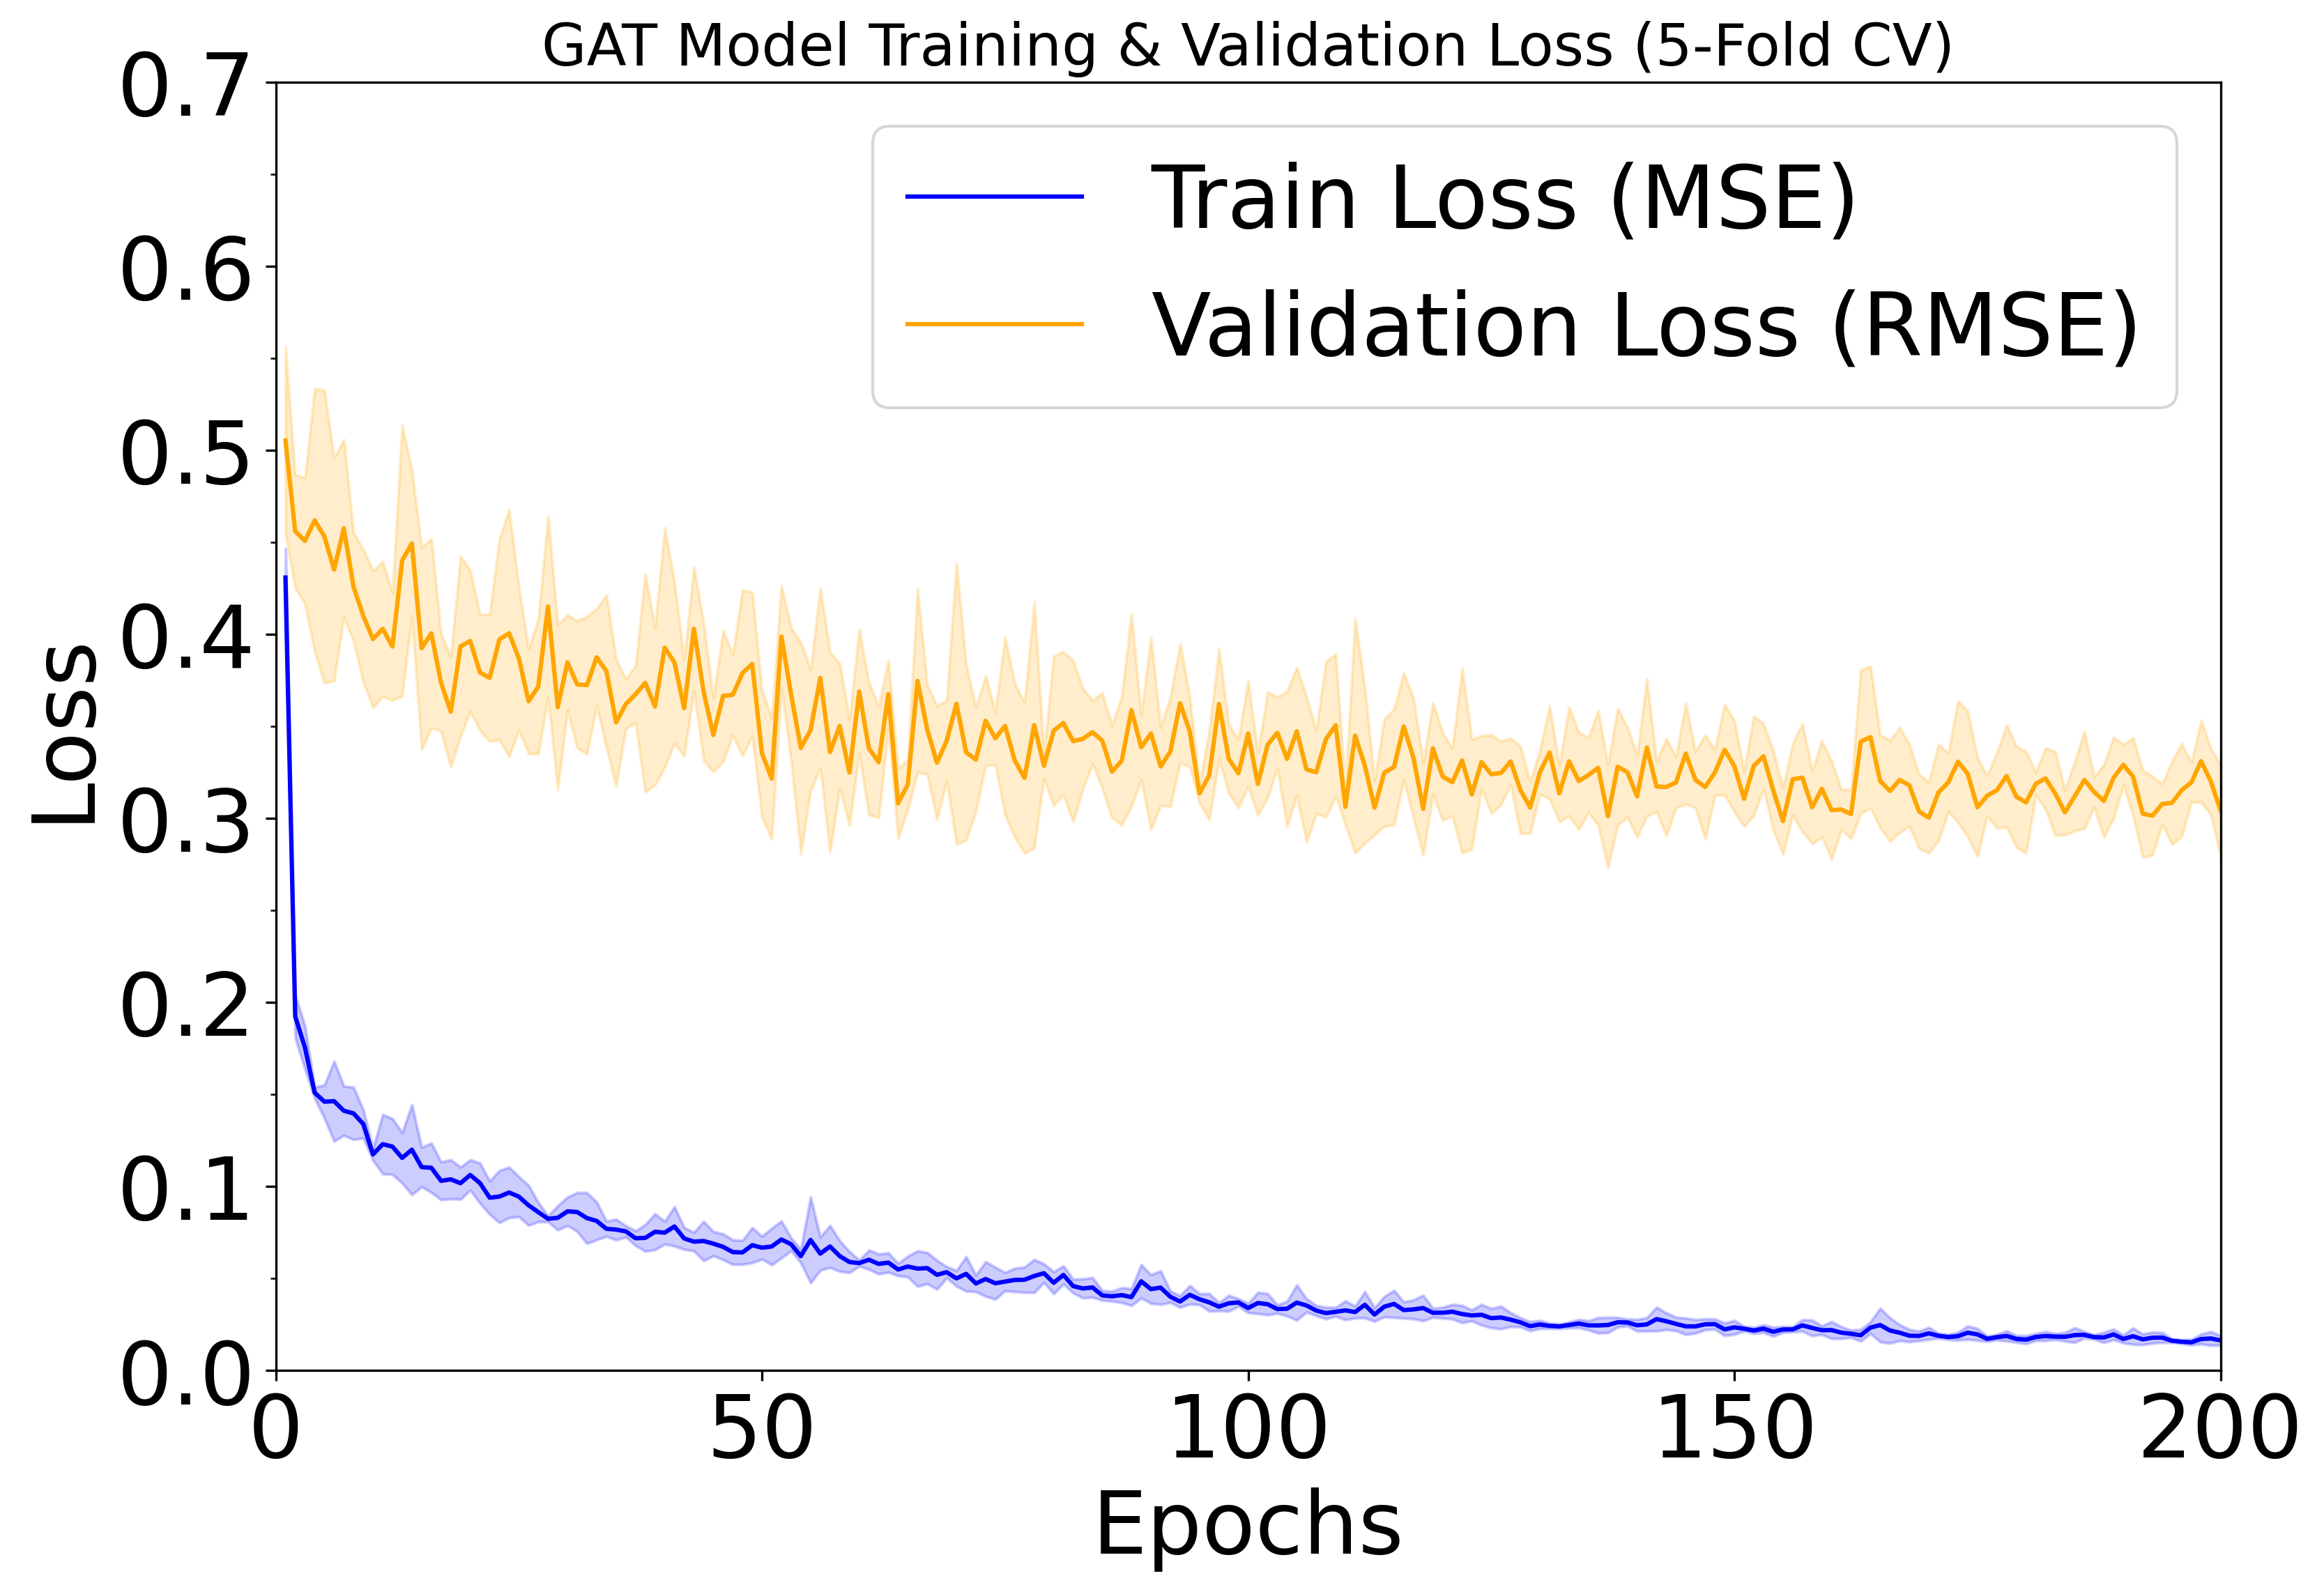

In [34]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

plt.title(f'GAT Model Training & Validation Loss ({k_folds}-Fold CV)', fontsize=20)
plt.xlabel('Epochs', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.legend(fontsize=30)
#plt.grid(True)
plt.xlim(0, max_epochs_run)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 0.7) #max(max_loss_val, max_loss_train) * 1.1)

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=20)
# add 1 minor ticks between each major tick
ax = plt.gca()
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=30)
plt.savefig('../Figures/GAT_kfold-cv_435.png', transparent=True, bbox_inches='tight')

### 3 heads, 3 conv, 5 FC

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment


# define the optimizer and 
import copy

# --- Prepare for K-Fold on Entire Dataset ---

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 5 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    # get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgs(edge_features = num_edge_features, num_features = num_node_features, epochs = 200, num_heads=3, num_fc_layers=5)

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')

    model = RexGAT(node_features=args.num_features,
                hidden_dim=args.hidden_dim,
                edge_features=args.edge_features,
                num_heads=args.num_heads,
                norm_type = args.norm_type,
                dropout=args.dropout,
                num_fc_layers=args.num_fc_layers,
                num_conv_layers=args.num_conv_layers).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None # Still useful if you want the best model *from that fold* for inspection
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse')
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) 
        current_val_loss = val_loss_rmse 

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 10 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)



print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')

--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 1450 labels for stratification.
Original Label Distribution: Counter({1: 1239, -1: 211})

--- Starting 5-Fold Cross-Validation ---

===== Fold 1/5 =====


/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 1160, Validation size: 290
Fold 1 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 1 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.31349, Val MSE: 0.21691, Val RMSE: 0.46425
  Epoch: 10, Loss - Train: 0.09312, Val MSE: 0.30024, Val RMSE: 0.54304
  Epoch: 20, Loss - Train: 0.08400, Val MSE: 0.09815, Val RMSE: 0.31167
  Epoch: 30, Loss - Train: 0.06548, Val MSE: 0.20858, Val RMSE: 0.45303
  Epoch: 40, Loss - Train: 0.05830, Val MSE: 0.14442, Val RMSE: 0.37805
  Epoch: 50, Loss - Train: 0.05573, Val MSE: 0.12336, Val RMSE: 0.34932
  Epoch: 60, Loss - Train: 0.04350, Val MSE: 0.10564, Val RMSE: 0.32384
  Epoch: 70, Loss - Train: 0.03421, Val MSE: 0.08805, Val RMSE: 0.29626
  Epoch: 80, Loss - Train: 0.03497, Val MSE: 0.10243, Val RMSE: 0.31895
  Epoch: 90, Loss - Train: 0.02289, Val MSE: 0.10275, Val RMSE: 0.31974
  Epoch: 100, Loss - Train: 0.02921, Val MSE: 0.07861, Val RMSE: 0.28024
  Epoch: 110, Loss - Train: 0.02034, Val MSE: 0.08300, Val RMSE: 0.28650
  Epoch: 120, Loss - Train: 0.02013, Val MSE: 0.09924, Val RMSE: 0.31226
  Epoch: 130, Loss - Train: 0.02131, Val MSE: 0.07725, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 2 - Train size: 1160, Validation size: 290
Fold 2 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 2 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.29270, Val MSE: 0.26591, Val RMSE: 0.51396
  Epoch: 10, Loss - Train: 0.11285, Val MSE: 0.13212, Val RMSE: 0.36004
  Epoch: 20, Loss - Train: 0.07965, Val MSE: 0.10780, Val RMSE: 0.32558
  Epoch: 30, Loss - Train: 0.06202, Val MSE: 0.11330, Val RMSE: 0.33401
  Epoch: 40, Loss - Train: 0.04924, Val MSE: 0.13401, Val RMSE: 0.36391
  Epoch: 50, Loss - Train: 0.03805, Val MSE: 0.13473, Val RMSE: 0.36513
  Epoch: 60, Loss - Train: 0.03238, Val MSE: 0.08917, Val RMSE: 0.29771
  Epoch: 70, Loss - Train: 0.02972, Val MSE: 0.10609, Val RMSE: 0.32398
  Epoch: 80, Loss - Train: 0.03691, Val MSE: 0.09844, Val RMSE: 0.31195
  Epoch: 90, Loss - Train: 0.01836, Val MSE: 0.09558, Val RMSE: 0.30834
  Epoch: 100, Loss - Train: 0.02037, Val MSE: 0.10789, Val RMSE: 0.32735
  Epoch: 110, Loss - Train: 0.01849, Val MSE: 0.09377, Val RMSE: 0.30560
  Epoch: 120, Loss - Train: 0.02082, Val MSE: 0.10821, Val RMSE: 0.32751
  Epoch: 130, Loss - Train: 0.01425, Val MSE: 0.11778, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 3 - Train size: 1160, Validation size: 290
Fold 3 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 3 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.32803, Val MSE: 0.20222, Val RMSE: 0.44602
  Epoch: 10, Loss - Train: 0.11255, Val MSE: 0.15877, Val RMSE: 0.39720
  Epoch: 20, Loss - Train: 0.07724, Val MSE: 0.10811, Val RMSE: 0.32782
  Epoch: 30, Loss - Train: 0.05849, Val MSE: 0.11552, Val RMSE: 0.33848
  Epoch: 40, Loss - Train: 0.05057, Val MSE: 0.12965, Val RMSE: 0.35686
  Epoch: 50, Loss - Train: 0.04658, Val MSE: 0.14778, Val RMSE: 0.38178
  Epoch: 60, Loss - Train: 0.03769, Val MSE: 0.10647, Val RMSE: 0.32129
  Epoch: 70, Loss - Train: 0.03250, Val MSE: 0.14131, Val RMSE: 0.37039
  Epoch: 80, Loss - Train: 0.03232, Val MSE: 0.11568, Val RMSE: 0.33504
  Epoch: 90, Loss - Train: 0.01961, Val MSE: 0.09358, Val RMSE: 0.30137
  Epoch: 100, Loss - Train: 0.01931, Val MSE: 0.08307, Val RMSE: 0.28446
  Epoch: 110, Loss - Train: 0.01880, Val MSE: 0.08480, Val RMSE: 0.28712
  Epoch: 120, Loss - Train: 0.01556, Val MSE: 0.09567, Val RMSE: 0.30709
  Epoch: 130, Loss - Train: 0.01761, Val MSE: 0.08780, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 4 - Train size: 1160, Validation size: 290
Fold 4 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 4 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.35719, Val MSE: 0.26127, Val RMSE: 0.50820
  Epoch: 10, Loss - Train: 0.09805, Val MSE: 0.17935, Val RMSE: 0.42107
  Epoch: 20, Loss - Train: 0.07461, Val MSE: 0.11173, Val RMSE: 0.33154
  Epoch: 30, Loss - Train: 0.06432, Val MSE: 0.09842, Val RMSE: 0.31050
  Epoch: 40, Loss - Train: 0.05397, Val MSE: 0.09712, Val RMSE: 0.30845
  Epoch: 50, Loss - Train: 0.05195, Val MSE: 0.10620, Val RMSE: 0.32238
  Epoch: 60, Loss - Train: 0.03898, Val MSE: 0.08913, Val RMSE: 0.29489
  Epoch: 70, Loss - Train: 0.03281, Val MSE: 0.18284, Val RMSE: 0.42518
  Epoch: 80, Loss - Train: 0.02545, Val MSE: 0.08344, Val RMSE: 0.28545
  Epoch: 90, Loss - Train: 0.02638, Val MSE: 0.09305, Val RMSE: 0.30345
  Epoch: 100, Loss - Train: 0.02145, Val MSE: 0.10589, Val RMSE: 0.32282
  Epoch: 110, Loss - Train: 0.02418, Val MSE: 0.09701, Val RMSE: 0.30881
  Epoch: 120, Loss - Train: 0.01616, Val MSE: 0.09715, Val RMSE: 0.30954
  Epoch: 130, Loss - Train: 0.01373, Val MSE: 0.09583, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 5 - Train size: 1160, Validation size: 290
Fold 5 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 5 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_3940988/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.36955, Val MSE: 0.19506, Val RMSE: 0.43972
  Epoch: 10, Loss - Train: 0.09845, Val MSE: 0.11839, Val RMSE: 0.34238
  Epoch: 20, Loss - Train: 0.08622, Val MSE: 0.14664, Val RMSE: 0.37975
  Epoch: 30, Loss - Train: 0.06823, Val MSE: 0.11568, Val RMSE: 0.33761
  Epoch: 40, Loss - Train: 0.05599, Val MSE: 0.11511, Val RMSE: 0.33603
  Epoch: 50, Loss - Train: 0.03989, Val MSE: 0.10831, Val RMSE: 0.32532
  Epoch: 60, Loss - Train: 0.03585, Val MSE: 0.07496, Val RMSE: 0.27063
  Epoch: 70, Loss - Train: 0.02915, Val MSE: 0.10846, Val RMSE: 0.32672
  Epoch: 80, Loss - Train: 0.04070, Val MSE: 0.10307, Val RMSE: 0.31879
  Epoch: 90, Loss - Train: 0.02028, Val MSE: 0.07836, Val RMSE: 0.27845
  Epoch: 100, Loss - Train: 0.02120, Val MSE: 0.07411, Val RMSE: 0.27044
  Epoch: 110, Loss - Train: 0.02152, Val MSE: 0.07488, Val RMSE: 0.27237
  Epoch: 120, Loss - Train: 0.01688, Val MSE: 0.08644, Val RMSE: 0.29238
  Epoch: 130, Loss - Train: 0.01708, Val MSE: 0.07472, Val RMS

In [55]:
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 5 folds: 0.26831 ± 0.01055
Average Best Validation MSE across 5 folds: 0.07291 ± 0.00595

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 0.26118 (MSE: 0.06856)
  Fold 2: 0.28396 (MSE: 0.08193)
  Fold 3: 0.26517 (MSE: 0.07074)
  Fold 4: 0.27648 (MSE: 0.07752)
  Fold 5: 0.25474 (MSE: 0.06578)


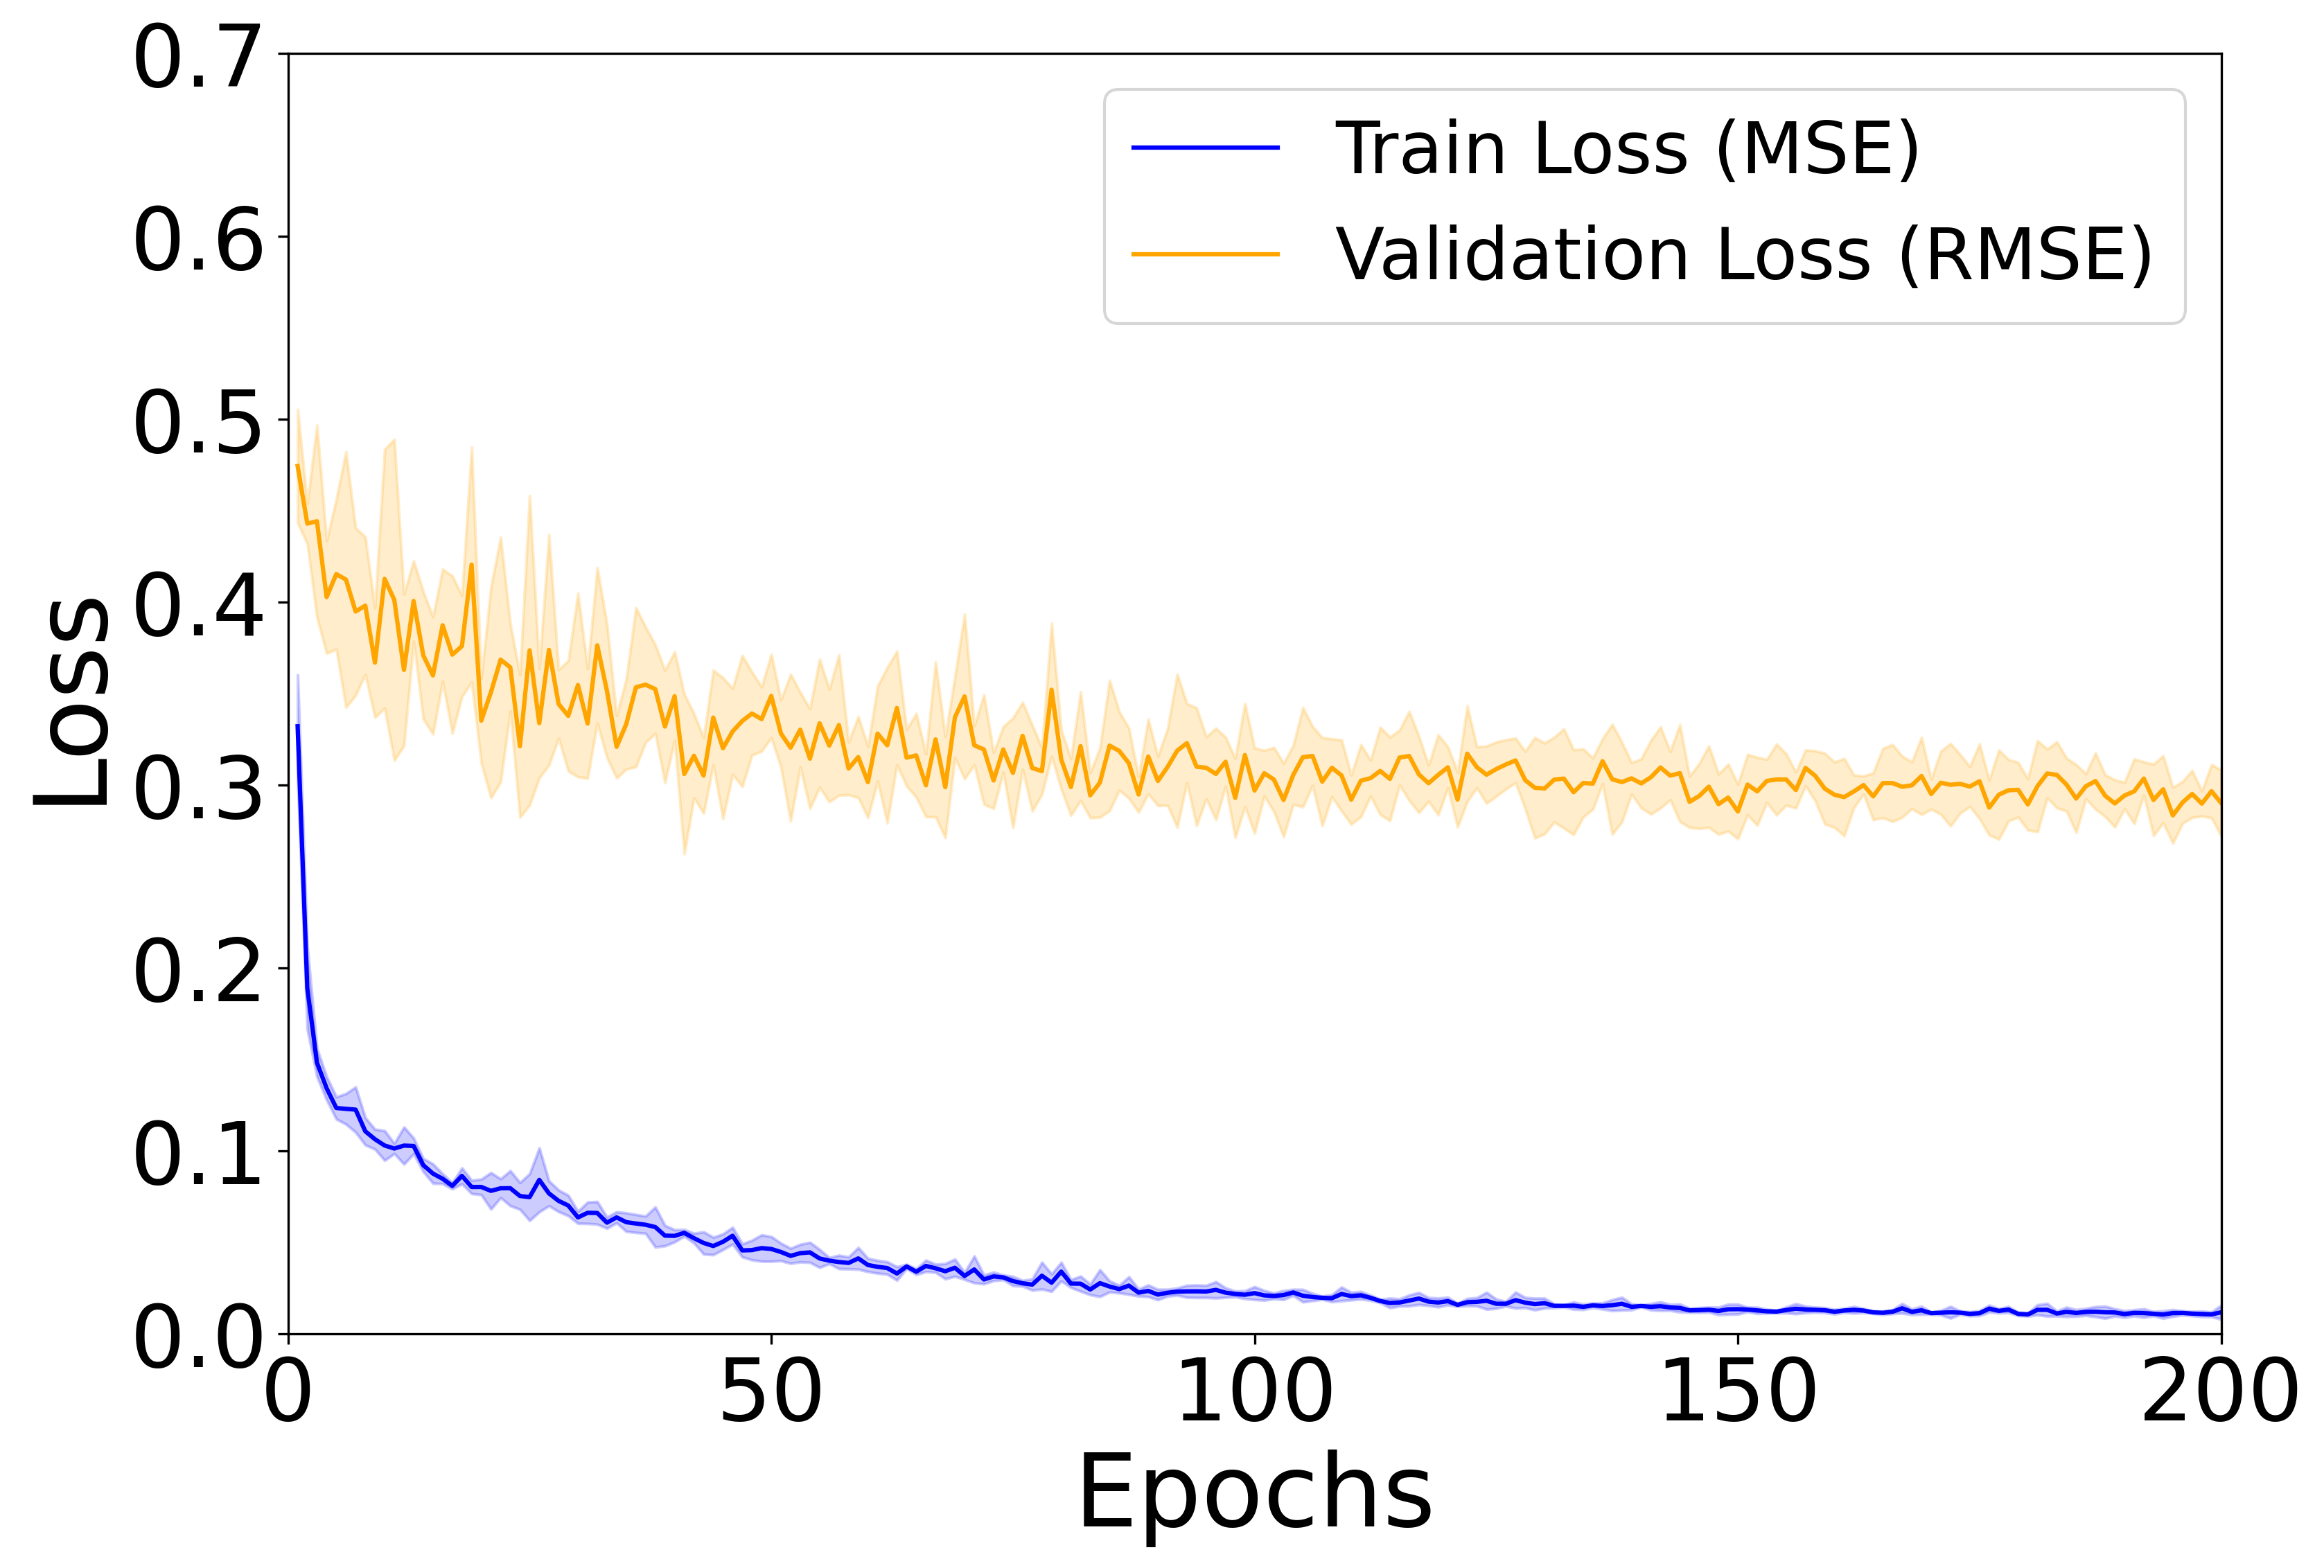

In [56]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

#plt.title(f'Average Training & Validation Loss ({k_folds}-Fold CV)', fontsize=25)
plt.xlabel('Epochs', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.legend(fontsize=25)
#plt.grid(True)
plt.xlim(0, 200)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 0.7)

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=30)
plt.savefig('../Figures/GAT_kfold-cv_335.png', transparent=True, bbox_inches='tight')

# Final Rep Model (using 3-3-5 model)

In [16]:
# Data splitting

from torch_geometric.loader import DataLoader
import random
from sklearn.model_selection import train_test_split

labels_for_stratification = [] #[data.y.item() for data in graph_data]
for data in final_df.y:
    y_value = data
    # Assign label based on the sign of the value
    if y_value < 0:
        labels_for_stratification.append(-1) # Assign -1 for negative values
    else: # Includes y_value >= 0 (including exactly 0)
        labels_for_stratification.append(1)  # Assign +1 for non-negative values

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
# Optional: Check label distribution
from collections import Counter
print("Original Label Distribution:", Counter(labels_for_stratification))


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15 # train + val + test = 1.0

# Indices for splitting data and labels together
indices = list(range(len(final_df)))

# First split: Separate Test set, stratifying by the labels
train_val_indices, test_indices, y_train_val, y_test_unused = train_test_split(
    indices, # Split indices first
    labels_for_stratification, # Labels corresponding to indices
    test_size=test_ratio,
    shuffle=True, # Shuffle before splitting
    stratify=labels_for_stratification, # Stratify based on the full label list
    random_state=42
)

# Second split: Separate Train and Validation sets from the train_val pool
# Stratify based on the labels remaining in the train_val pool (y_train_val)
# Calculate the validation proportion relative to the train_val pool size
val_proportion_of_train_val = val_ratio / (train_ratio + val_ratio)

train_indices, val_indices, y_train_unused, y_val_unused = train_test_split(
    train_val_indices, # Split the indices reserved for train/val
    y_train_val,       # Labels corresponding to train_val_indices
    test_size=val_proportion_of_train_val,
    shuffle=True, # shuffle False does not work with stratification lol
    stratify=y_train_val, # Stratify based on the train_val labels
    random_state=52 
)

# Create the final data splits using the selected indices

# get train df
train_fold_df = final_df.iloc[train_indices]
# get mask for mfp from train data
target_y = train_fold_df['y'].values
descriptors = None
for i,mol in enumerate(train_fold_df['mol']):
    x = compute_morgan_fingerprint(mol)
    if i == 0:
        descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
    descriptors[i]=x
mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)

# get val and test df
val_fold_df = final_df.iloc[val_indices]
test_fold_df = final_df.iloc[test_indices]

# Generate graph data
train_data = GenGraphs(train_fold_df, mfp_mask=mfp_mask_128)  # [graph_data[i] for i in train_indices]
val_data = GenGraphs(val_fold_df, mfp_mask=mfp_mask_128)   # [graph_data[i] for i in val_indices]
test_data = GenGraphs(test_fold_df, mfp_mask=mfp_mask_128)   # [graph_data[i] for i in test_indices]

num_node_features = train_data[0].x.size(1)
num_edge_features = train_data[0].edge_attr.size(1)

# --- Verification ---
print(f'\n--- Split Sizes ---')
print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')
print(f'Total: {len(train_data) + len(val_data) + len(test_data)} (should match original)')

print(f'\n--- Class Distribution Verification ---')
train_labels_orig = [d.y.item() for d in train_data]
val_labels_orig = [d.y.item() for d in val_data]
test_labels_orig = [d.y.item() for d in test_data]

print(f"Train +/- ratio: {sum(1 for y in train_labels_orig if y>=0)} / {sum(1 for y in train_labels_orig if y<0)}")
print(f"Val +/- ratio: {sum(1 for y in val_labels_orig if y>=0)} / {sum(1 for y in val_labels_orig if y<0)}")
print(f"Test +/- ratio: {sum(1 for y in test_labels_orig if y>=0)} / {sum(1 for y in test_labels_orig if y<0)}")


Extracted 1450 labels for stratification.
Original Label Distribution: Counter({1: 1239, -1: 211})


/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.

--- Split Sizes ---
Train size: 1014
Validation size: 218
Test size: 218
Total: 1450 (should match original)

--- Class Distribution Verification ---
Train +/- ratio: 867 / 147
Val +/- ratio: 186 / 32
Test +/- ratio: 186 / 32


In [17]:
class TrainArgs:
    def __init__(self,
                 edge_features=None,  # Provide default values
                 num_features=None,   # Provide default values
                 dropout=0.1,
                 norm_type='layer',
                 num_heads=3, #4,
                 num_conv_layers=3,
                 num_fc_layers=5,
                 hidden_dim=512,
                 batch_size=64,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-4,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):
        # Assign arguments to instance attributes
        self.edge_features = edge_features
        self.num_features = num_features
        self.dropout = dropout
        self.norm_type = norm_type
        self.num_heads = num_heads
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience

args = TrainArgs(edge_features = num_edge_features, num_features = num_node_features)


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_gat = RexGAT(node_features=args.num_features,
                hidden_dim=args.hidden_dim,
                edge_features=args.edge_features,
                num_heads=args.num_heads,
                norm_type = args.norm_type,
                dropout=args.dropout,
                num_fc_layers=args.num_fc_layers,
                num_conv_layers=args.num_conv_layers).to(device)
## print model parameters
print(model_gat)
print("Number of parameters: ", sum(p.numel() for p in model_gat.parameters()))

RexGAT: Adding input projection layer (119 -> 512) for residual connection.
RexGAT(
  (conv_list): ModuleList(
    (0): RexGATConv(in=119, out=512, edge_dim=10, heads=3)
    (1-2): 2 x RexGATConv(in=512, out=512, edge_dim=10, heads=3)
  )
  (norm_list): ModuleList(
    (0-2): 3 x LayerNorm(512, affine=True, mode=graph)
  )
  (input_proj): Linear(in_features=119, out_features=512, bias=True)
  (fc_list): ModuleList(
    (0-3): 4 x Linear(in_features=1024, out_features=1024, bias=True)
  )
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of parameters:  6816859


In [18]:
import copy

model = model_gat
args = args

# optimizer
params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = torch.optim.Adam(params)
criterion = torch.nn.MSELoss()


# DataLoaders
batch_size = args.batch_size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_loader_noshuffle = DataLoader(train_data, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created successfully.")

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_loader) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)


# Early Stopping variables
patience = args.patience # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

#train  
train_losses = []
val_losses = []
val_losses_rmse = []
test_losses = []
for epoch in range(1, args.epochs):
    #train_loss = train(train_loader) #train(train_loader)
    train_loss = train(train_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse') #train(train_loader)
    val_loss = evaluate(val_loader, model=model) #test(test_loader)
    val_loss_rmse = evaluate_rmse(val_loader, model=model) #test(test_loader)
    current_val_loss = val_loss_rmse
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_losses_rmse.append(val_loss_rmse)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:d}, Loss - Train: {train_loss:.7f}, Val MSE: {val_loss:.7f}, Val RMSE: {val_loss_rmse:.7f}')
    
    # --- Early Stopping Check ---
    if epoch > 0:
        improved = False
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            improved = True

        if improved:
            patience_counter = 0 # Reset patience
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            print(f'   -> Validation loss improved to {best_val_loss:.7f}. Saving model state.')
        else:
            patience_counter += 1
            print(f'   -> Validation metric did not improve. Patience: {patience_counter}/{patience}')

        if patience_counter >= patience:
            print(f'!!! Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch} with Val Loss: {best_val_loss:.5f}')
            break # Exit the training loop

# --- After Training Loop ---
# Load the best model state found during training
if best_model_state:
    print("Loading best model state for final evaluation.")
    model.load_state_dict(best_model_state)
    # model.load_state_dict(torch.load('best_model.pth')) # If saved to disk
else:
    print("Warning: No best model state saved (perhaps training ended too early or validation loss never improved).")

# Final evaluation on the test set using the best model
print("Evaluating final model on Test Set...")
final_train_mse = evaluate(train_loader, model=model)
final_train_rmse = evaluate_rmse(train_loader, model=model)
final_val_mse = evaluate(val_loader, model=model)
final_val_rmse = evaluate_rmse(val_loader, model=model)
final_test_mse = evaluate(test_loader, model=model)
final_test_rmse = evaluate_rmse(test_loader, model=model)
print(f'Final Train Loss (best model): MSE {final_train_mse:.4f}, RMSE {final_train_rmse:.4f}')
print(f'Final Val Loss (best model): MSE {final_val_mse:.4f}, RMSE {final_val_rmse:.4f}')
print(f'Final Test Loss (best model): MSE {final_test_mse:.4f}, RMSE {final_test_rmse:.4f}')





DataLoaders created successfully.
Using device: cuda:1


/var/tmp/pbs.83507.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_1181894/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.83507.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_1181894/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


Epoch: 1, Loss - Train: 0.3355888, Val MSE: 0.2530600, Val RMSE: 0.5010330
   -> Validation loss improved to 0.5010330. Saving model state.
Epoch: 2, Loss - Train: 0.1649948, Val MSE: 0.1885081, Val RMSE: 0.4312119
   -> Validation loss improved to 0.4312119. Saving model state.
Epoch: 3, Loss - Train: 0.1547890, Val MSE: 0.2103141, Val RMSE: 0.4563624
   -> Validation metric did not improve. Patience: 1/50
Epoch: 4, Loss - Train: 0.1282874, Val MSE: 0.1733303, Val RMSE: 0.4143322
   -> Validation loss improved to 0.4143322. Saving model state.
Epoch: 5, Loss - Train: 0.1234495, Val MSE: 0.2550854, Val RMSE: 0.5025809
   -> Validation metric did not improve. Patience: 1/50
Epoch: 6, Loss - Train: 0.1217377, Val MSE: 0.1555751, Val RMSE: 0.3929215
   -> Validation loss improved to 0.3929215. Saving model state.
Epoch: 7, Loss - Train: 0.1159768, Val MSE: 0.1395370, Val RMSE: 0.3714754
   -> Validation loss improved to 0.3714754. Saving model state.
Epoch: 8, Loss - Train: 0.1159346, Val

In [32]:
# Final evaluation on the test set using the best model
print("Evaluating final model on Test Set...")
final_train_mse = evaluate(train_loader, model=model)
final_train_rmse = evaluate_rmse(train_loader, model=model)
final_val_mse = evaluate(val_loader, model=model)
final_val_rmse = evaluate_rmse(val_loader, model=model)
final_test_mse = evaluate(test_loader, model=model)
final_test_rmse = evaluate_rmse(test_loader, model=model)
print(f'Final Train Loss (best model): MSE {final_train_mse:.4f}, RMSE {final_train_rmse:.4f}')
print(f'Final Val Loss (best model): MSE {final_val_mse:.4f}, RMSE {final_val_rmse:.4f}')
print(f'Final Test Loss (best model): MSE {final_test_mse:.4f}, RMSE {final_test_rmse:.4f}')

Evaluating final model on Test Set...
Final Train Loss (best model): MSE 0.0257, RMSE 0.1599
Final Val Loss (best model): MSE 0.0986, RMSE 0.3130
Final Test Loss (best model): MSE 0.0797, RMSE 0.2772


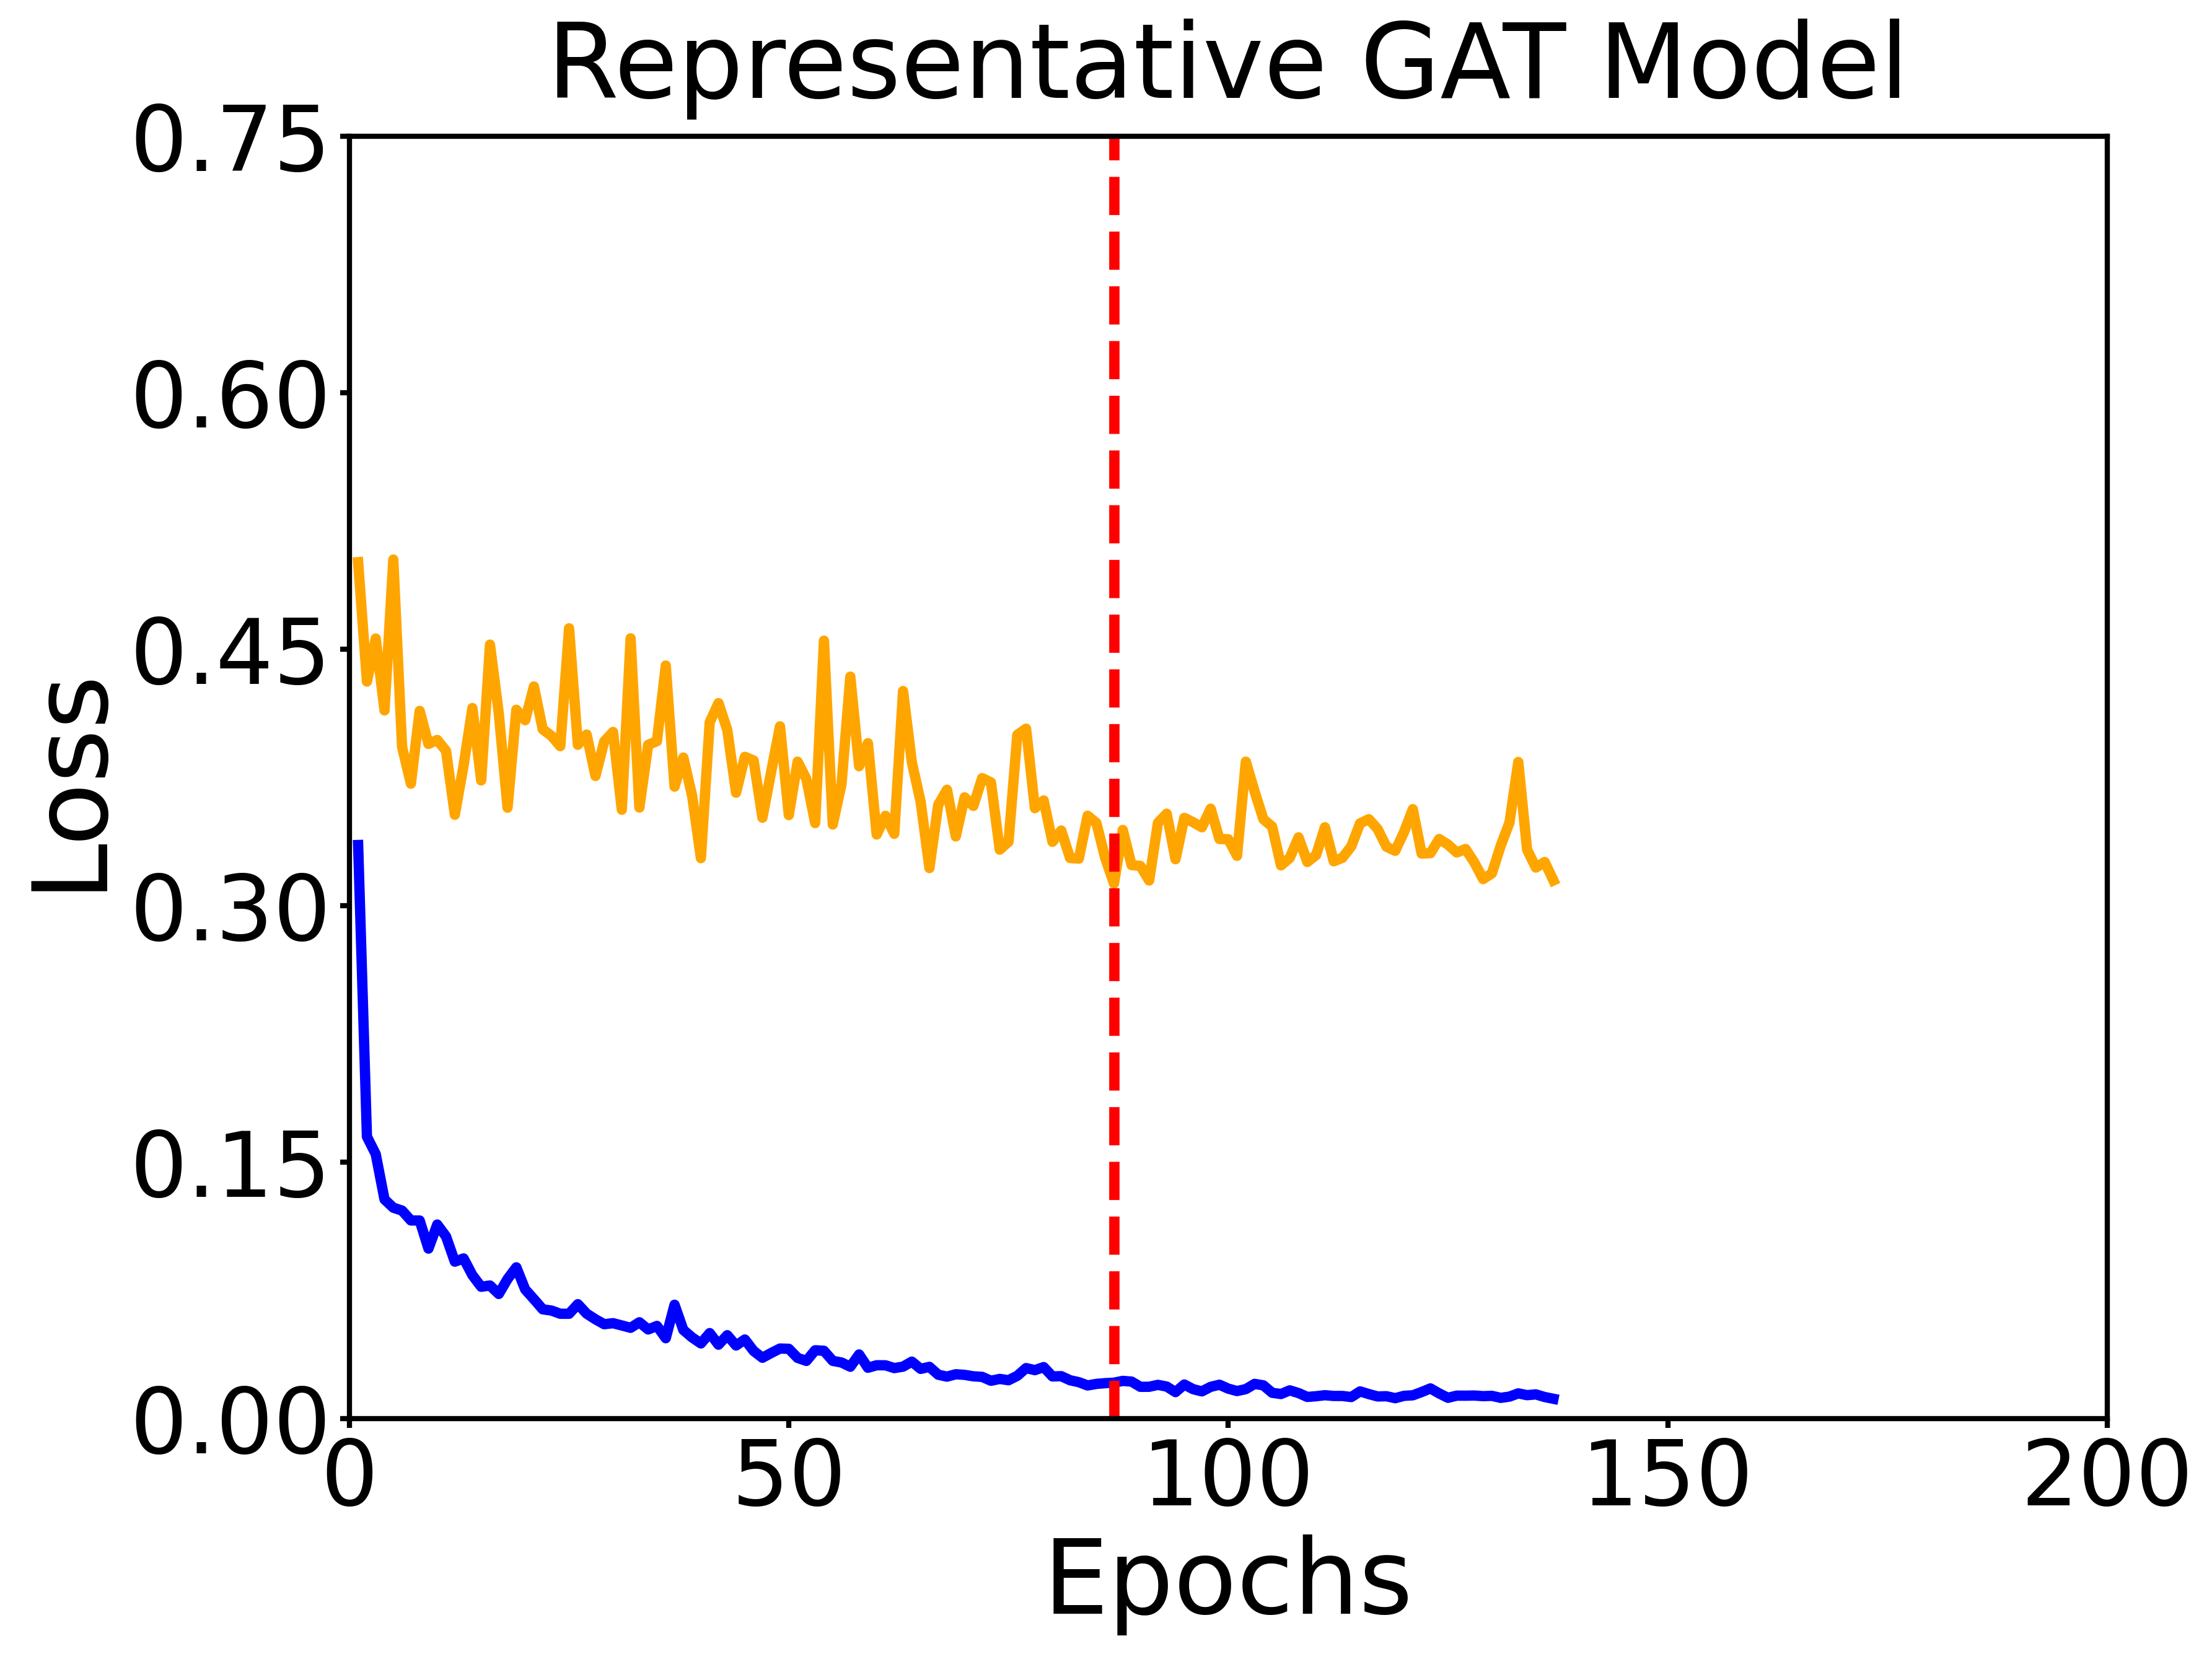

In [29]:
import math

# visualize the loss as the network trained
fig, ax = plt.subplots(figsize=(12,9),dpi=300) # Slightly larger figure for bigger fonts

for spine in ax.spines.values():
    spine.set_linewidth(2)  # Change 2 to desired thickness

epochs = list(range(1, len(train_losses) + 1)) # X-axis data
data = {
    'epoch': epochs,
    'training_loss_(mse)': train_losses
}
data_df = pd.DataFrame(data)
output_filepath = "../Figures/GAT_rep-model.txt"
data_df.to_csv(output_filepath, index=False)

plt.plot(epochs,train_losses, c='b', label='Training Loss (MSE)', linewidth=4)
plt.plot(epochs,val_losses_rmse, c='orange', label='Validation Loss (RMSE)', linewidth=4)

if best_epoch != -1: # Indicate best epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=4)

# --- Fontsize Modifications ---
plt.title('Representative GAT Model', fontsize=40, pad=15) # Increased title fontsize
plt.xlabel('Epochs', fontsize=40) # Increased x-label fontsize
plt.ylabel('Loss', fontsize=40) # Increased y-label fontsize
#plt.legend(fontsize=32, loc='upper left') # Increased legend fontsize
plt.tick_params(axis='both', which='major', width=2, labelsize=35) # Increased tick label size

num_epochs_run = len(val_losses_rmse)
plt.xlim(0, 200)

plt.ylim(0, 0.75)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))

#plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig('../Figures/GAT_rep-model.png', transparent=True, bbox_inches='tight')
plt.show()

Plotting results and finding outliers with threshold = 0.8...
Processing Training data...
R² Score Train set: 0.936
Found and stored 0 outliers in Train set.
R² Score Validation set: 0.761
Found and stored 7 outliers in Validation set.
R² Score Test set: 0.807
Found and stored 5 outliers in Test set.

Total number of unique outliers found: 12
{ 16: {'pred': 0.9368016719818115, 'true': 1.7953169345855713},
  70: {'pred': 1.57841157913208, 'true': 2.449955940246582},
  167: {'pred': 0.7685289978981018, 'true': 1.7170413732528687},
  275: {'pred': -0.33080416917800903, 'true': 0.5440060496330261},
  310: {'pred': 1.4037388563156128, 'true': 0.4000146687030792},
  396: {'pred': 1.1078219413757324, 'true': 1.9295051097869873},
  495: {'pred': 0.4812050759792328, 'true': 1.5163600444793701},
  632: {'pred': 1.0057787895202637, 'true': 1.890453815460205},
  1087: {'pred': -0.42818933725357056, 'true': -1.2447383403778076},
  1113: {'pred': -0.6112471222877502, 'true': 0.7562918663024902},
  1

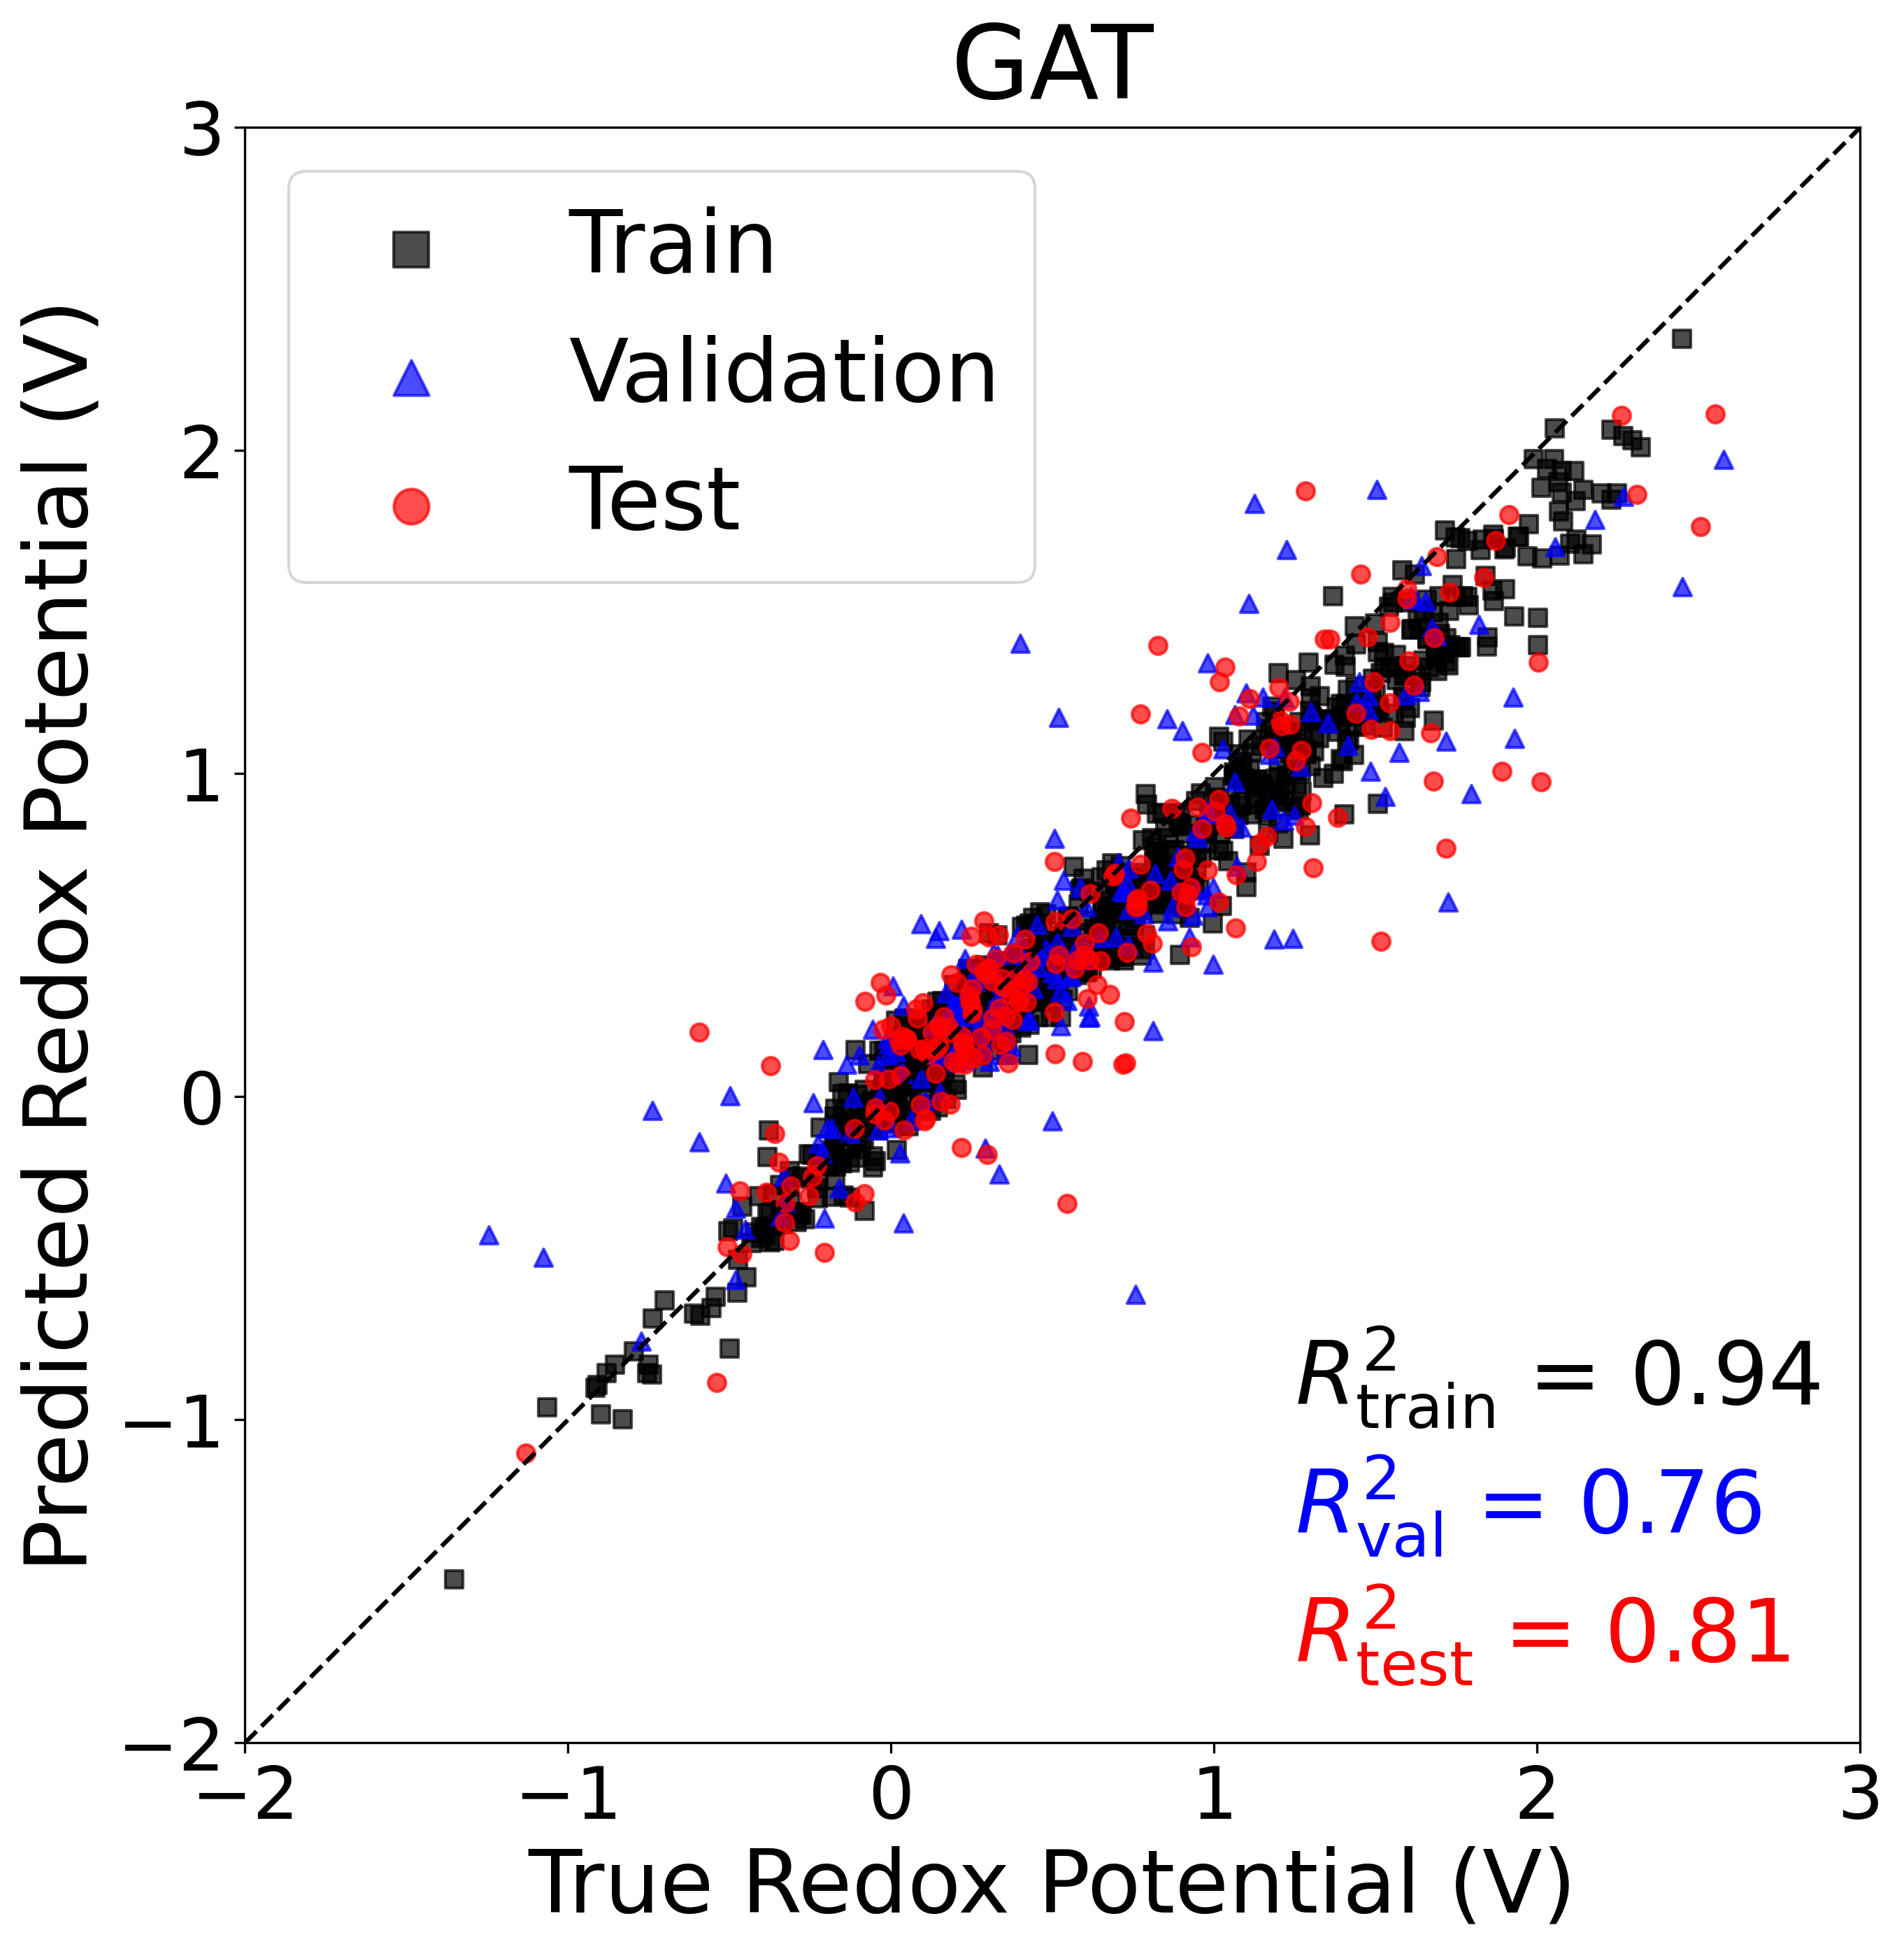

In [30]:
import pprint
import pandas as pd

# --- Configuration ---
outlier_threshold = 0.8

# --- Set model to evaluation mode ---
model.eval()

# --- Initialize dictionary for original outlier info ---
original_outlier_info = {} 
# Outliers are not plotted here

# --- Initialize Plotting ---
print(f"Plotting results and finding outliers with threshold = {outlier_threshold}...")
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

title_fontsize = 35
axlabel_fontsize = 30
ticklabel_fontsize = 25

# --------------------------------------------------
# Helper function to process a split (train/val/test)
# --------------------------------------------------
def process_split(loader, indices, split_name):
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            y_true.append(data.y)
            y_pred.append(model(data))
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

    # Calculate R²
    r2_val = round(r2_score(y_true, y_pred), 3)
    print(f"R² Score {split_name} set: {r2_val}")

    # Identify outliers
    error = np.abs(y_true - y_pred)
    outlier_mask = error >= outlier_threshold
    split_outlier_indices = np.where(outlier_mask)[0]

    num_outliers = 0
    for split_idx in split_outlier_indices:
        original_idx = indices[split_idx]
        true_val = y_true[split_idx].item()
        pred_val = y_pred[split_idx].item()
        if original_idx not in original_outlier_info:
            original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
            num_outliers += 1
    print(f"Found and stored {num_outliers} outliers in {split_name} set.")

    return y_true, y_pred, r2_val

# --------------------------------------------------
# Process Train / Val / Test
# --------------------------------------------------
print("Processing Training data...")
if 'train_loader_noshuffle' not in locals():
    print("Warning: 'train_loader_noshuffle' not found. Creating one. Ensure train_data exists.")
    train_loader_noshuffle = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)

y_true_train, y_pred_train, r2_train = process_split(train_loader_noshuffle, train_indices, "Train")
y_true_val,   y_pred_val,   r2_val   = process_split(val_loader,   val_indices,   "Validation")
y_true_test,  y_pred_test,  r2_test  = process_split(test_loader,  test_indices,  "Test")

# --------------------------------------------------
# Plot all together
# --------------------------------------------------
ax.scatter(y_true_train, y_pred_train, color='black', alpha=0.7, marker='s', label='Train')
ax.scatter(y_true_val,   y_pred_val,   color='blue', alpha=0.7, marker='^', label='Validation')
ax.scatter(y_true_test,  y_pred_test,  color='red', alpha=0.7, marker='o', label='Test')

# Ideal line
ax.plot([-2, 3], [-2, 3], 'k--', linewidth=1.5) #, label='Ideal (y=x)')

# Labels, ticks, formatting
ax.set_xlabel("True Redox Potential (V)", fontsize=axlabel_fontsize)
ax.set_ylabel("Predicted Redox Potential (V)", fontsize=axlabel_fontsize)
ax.set_title("GAT", fontsize=title_fontsize, pad=10)
ax.set_xlim(-2, 3)
ax.set_xticks(np.arange(-2, 3.1, 1))
ax.set_ylim(-2, 3)
ax.set_yticks(np.arange(-2, 3.1, 1))
ax.tick_params(axis='both', which='major', labelsize=ticklabel_fontsize)
ax.set_aspect('equal', adjustable='box')
ax.legend(fontsize=30, loc='upper left', markerscale=2)

# Print R² values on plot (in matching colors)
ax.text(0.65, 0.21, r"$R^{2}_{\text{train}}$ = " + f"{r2_train:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='black') # , bbox=dict(facecolor='white', alpha=0.8)
ax.text(0.65, 0.13, r"$R^{2}_{\text{val}}$ = " + f"{r2_val:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='blue') # , bbox=dict(facecolor='white', alpha=0.8)
ax.text(0.65, 0.05, r"$R^{2}_{\text{test}}$ = " + f"{r2_test:.2f}", transform=ax.transAxes, 
        ha='left', fontsize=30, color='red') # , bbox=dict(facecolor='white', alpha=0.8)

# --------------------------------------------------
# Save data to files
# --------------------------------------------------
pd.DataFrame({
    'true': y_true_train.ravel(),
    'pred': y_pred_train.ravel()
}).to_csv("../Figures/GAT_train_parity.txt", sep="\t", index=False)

pd.DataFrame({
    'true': y_true_val.ravel(),
    'pred': y_pred_val.ravel()
}).to_csv("../Figures/GAT_val_parity.txt", sep="\t", index=False)

pd.DataFrame({
    'true': y_true_test.ravel(),
    'pred': y_pred_test.ravel()
}).to_csv("../Figures/GAT_test_parity.txt", sep="\t", index=False)


# --------------------------------------------------
# Finalize
# --------------------------------------------------
sorted_outlier_info = dict(sorted(original_outlier_info.items()))
print(f"\nTotal number of unique outliers found: {len(sorted_outlier_info)}")
pprint.pprint(sorted_outlier_info, indent=2)

plt.savefig('../Figures/GAT_parity.png', transparent=True, bbox_inches='tight')
plt.show()


Plotting results and finding outliers with threshold = 0.8...
Processing Training data...
R² Score Train set: 0.936
Found and stored 0 outliers in train set.
Processing Validation data...
R² Score Val set: 0.761
Found and stored 7 new outliers in validation set.
Processing Test data...
R² Score Test set: 0.807
Found and stored 5 new outliers in test set.

Total number of unique outliers found: 12
Original indices and values of outliers (from graph_data):
{ 16: {'pred': 0.9368016719818115, 'true': 1.7953169345855713},
  70: {'pred': 1.5784118175506592, 'true': 2.449955940246582},
  167: {'pred': 0.768528938293457, 'true': 1.7170413732528687},
  275: {'pred': -0.3308041989803314, 'true': 0.5440060496330261},
  310: {'pred': 1.4037384986877441, 'true': 0.4000146687030792},
  396: {'pred': 1.1078221797943115, 'true': 1.9295051097869873},
  495: {'pred': 0.4812051057815552, 'true': 1.5163600444793701},
  632: {'pred': 1.0057787895202637, 'true': 1.890453815460205},
  1087: {'pred': -0.42818

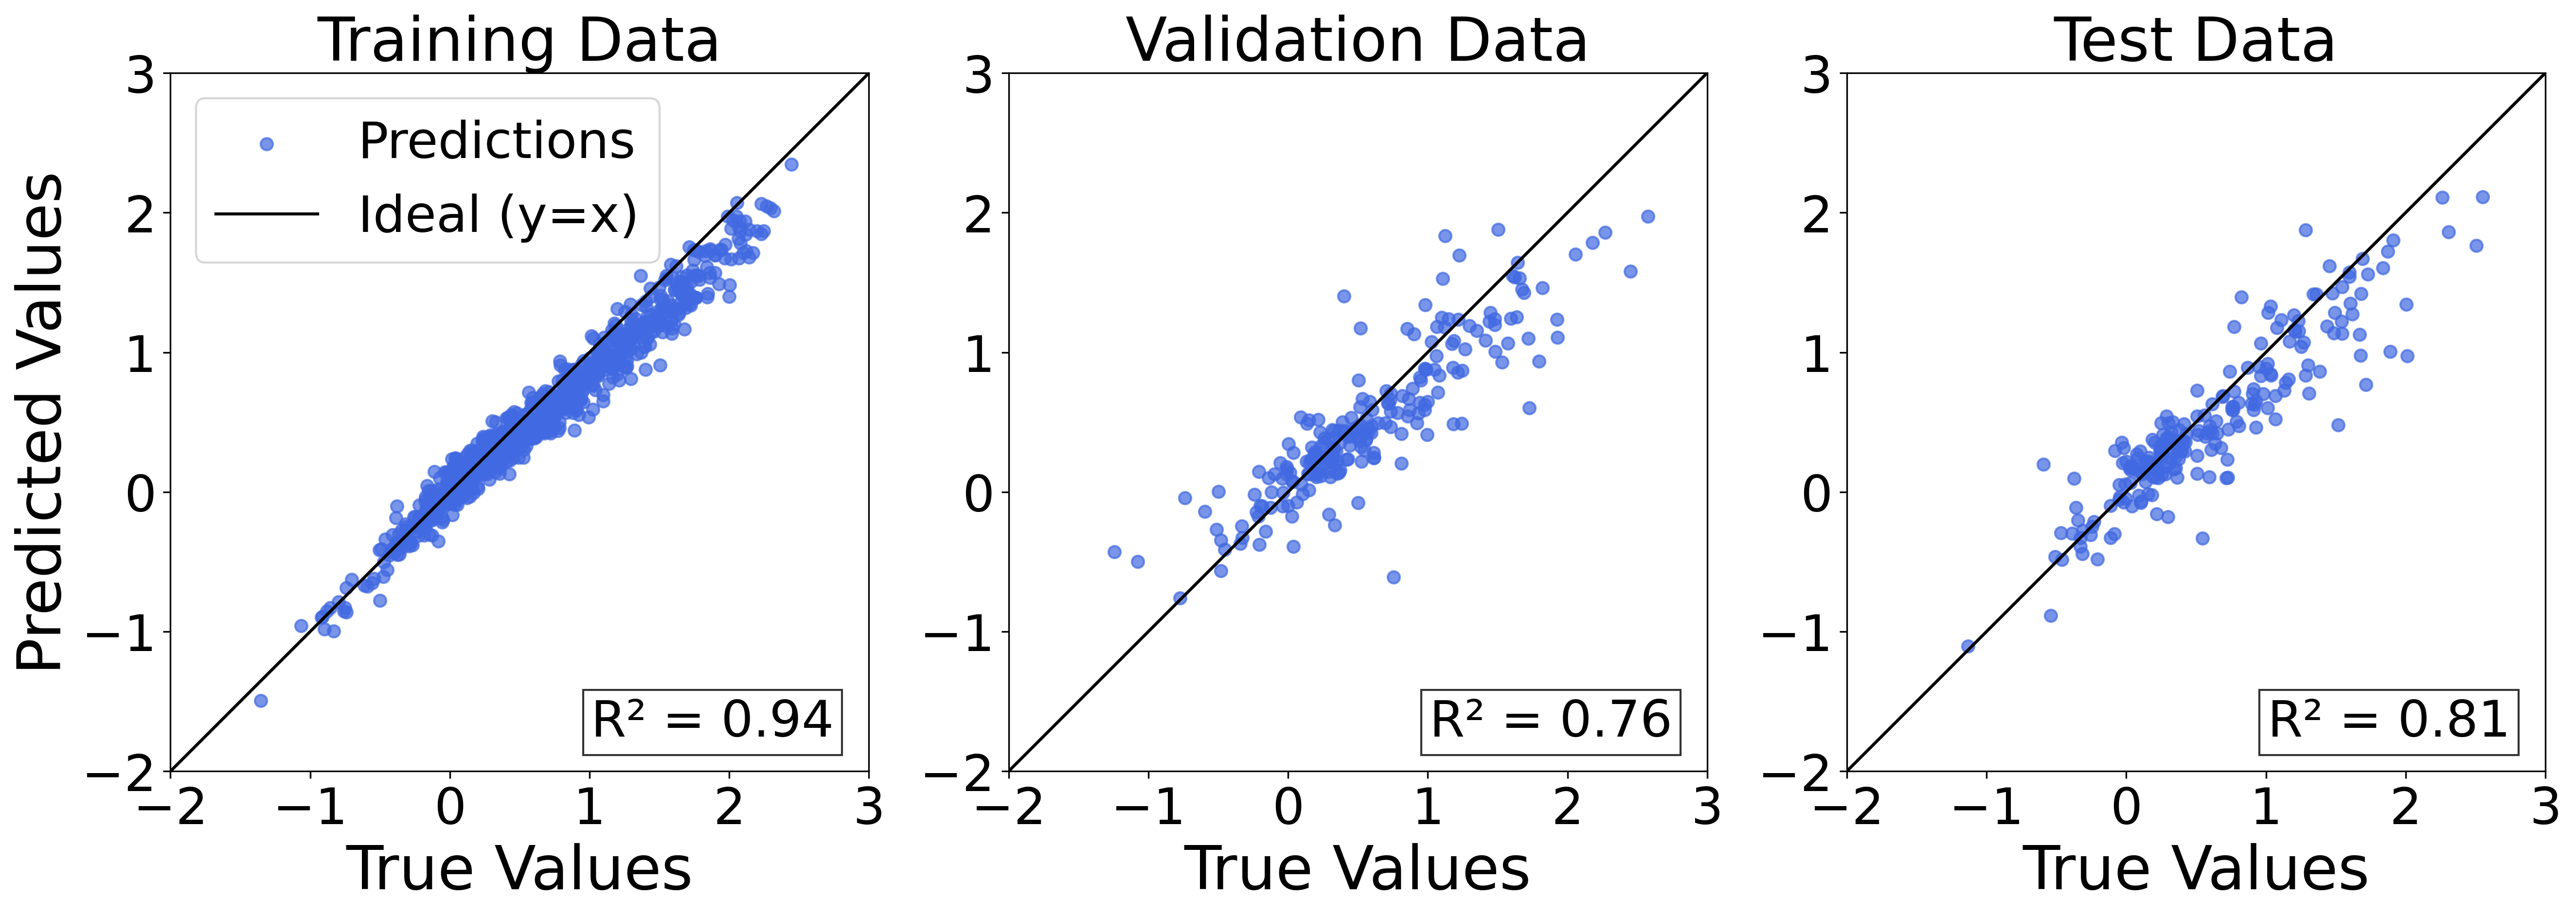

In [31]:
import pprint

# --- Configuration ---
outlier_threshold = 0.8


# --- Set model to evaluation mode ---
model.eval()

# --- Initialize dictionary for original outlier info ---
original_outlier_info = {} # Changed from list to dict

# --- Initialize Plotting ---
print(f"Plotting results and finding outliers with threshold = {outlier_threshold}...")
fig, axes = plt.subplots(1, 3, figsize=(21, 10), dpi=300)
# fig.suptitle('Predicted vs. True Values - Outlier Visualization', fontsize=16)

# --- Process Train Data (Using non-shuffled loader for index mapping) ---
print("Processing Training data...")
y_true_train = []
y_pred_train = []
# IMPORTANT: Use a non-shuffled loader for the training set to map indices correctly
if 'train_loader_noshuffle' not in locals():
     print("Warning: 'train_loader_noshuffle' not found. Creating one. Ensure train_data exists.")
     train_loader_noshuffle = DataLoader(train_data, batch_size=args.batch_size, shuffle=False)

with torch.no_grad():
    for data in train_loader_noshuffle: # Use the non-shuffled loader here
        data = data.to(device)
        y_true_train.append(data.y)
        y_pred_train.append(model(data))

y_true_train = torch.cat(y_true_train, dim=0).cpu().numpy()
y_pred_train = torch.cat(y_pred_train, dim=0).cpu().numpy()

# Calculate R²
r2_train = round(r2_score(y_true_train, y_pred_train), 3)
print(f"R² Score Train set: {r2_train}")

# Identify outliers
error_train = np.abs(y_true_train - y_pred_train)
outlier_mask_train = error_train >= outlier_threshold 
non_outlier_mask_train = ~outlier_mask_train

# Find outlier indices within the split
split_outlier_indices_train = np.where(outlier_mask_train)[0]

# --- Store outlier info in the dictionary ---
num_outliers_train = 0
for split_idx in split_outlier_indices_train:
    original_idx = train_indices[split_idx]
    true_val = y_true_train[split_idx].item() # Use .item() to get scalar value
    pred_val = y_pred_train[split_idx].item() # Use .item() to get scalar value
    original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
    num_outliers_train += 1
print(f"Found and stored {num_outliers_train} outliers in train set.")

# Train Data Plot (Plotting code remains the same)
title_fontsize = 30
axlabel_fontsize = 30
ticklabel_fontsize = 25

axes[0].scatter(y_true_train, y_pred_train,
                color='royalblue', alpha=0.7, label='Predictions')
axes[0].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')
axes[0].set_xlabel("True Values", fontsize = axlabel_fontsize)
axes[0].set_ylabel("Predicted Values", fontsize = axlabel_fontsize)
axes[0].set_title("Training Data", fontsize = title_fontsize)
axes[0].legend(fontsize = 25)
#axes[0].grid(True)
axes[0].set_xlim(-2, 3)
axes[0].set_xticks(np.arange(-2, 3.1, 1))
axes[0].set_ylim(-2, 3)
axes[0].set_yticks(np.arange(-2, 3.1, 1))
axes[0].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[0].set_aspect('equal', adjustable='box')
axes[0].text(0.95, 0.05, f"R² = {r2_train:.2f}", transform=axes[0].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))

# --- Process Validation Data ---
print("Processing Validation data...")
y_true_val = []
y_pred_val = []
with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        y_true_val.append(data.y)
        y_pred_val.append(model(data))

y_true_val = torch.cat(y_true_val, dim=0).cpu().numpy()
y_pred_val = torch.cat(y_pred_val, dim=0).cpu().numpy()

# Calculate R²
r2_val = round(r2_score(y_true_val, y_pred_val), 3)
print(f"R² Score Val set: {r2_val}")

# Identify outliers
error_val = np.abs(y_true_val - y_pred_val)
outlier_mask_val = error_val >= outlier_threshold # Fixed HTML entity
non_outlier_mask_val = ~outlier_mask_val

# Find outlier indices within the split
split_outlier_indices_val = np.where(outlier_mask_val)[0]

# --- Store outlier info in the dictionary ---
num_outliers_val = 0
for split_idx in split_outlier_indices_val:
    original_idx = val_indices[split_idx]
    true_val = y_true_val[split_idx].item()
    pred_val = y_pred_val[split_idx].item()
    # Check if index already exists (e.g., if a point was somehow in multiple splits - unlikely but safe)
    if original_idx not in original_outlier_info:
         original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
         num_outliers_val += 1
    else:
         print(f"Warning: Index {original_idx} from validation set already found as outlier.")
print(f"Found and stored {num_outliers_val} new outliers in validation set.")


# Validation Data Plot (Plotting code remains the same)
axes[1].scatter(y_true_val, y_pred_val,
                color='royalblue', alpha=0.7, label='Non-Outliers')
axes[1].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')
axes[1].set_xlabel("True Values", fontsize = axlabel_fontsize)
#axes[1].set_ylabel("Predicted Values")
axes[1].set_title("Validation Data", fontsize = title_fontsize)
#axes[1].legend()
#axes[1].grid(True)
axes[1].set_xlim(-2, 3)
axes[1].set_xticks(np.arange(-2, 3.1, 1))
axes[1].set_ylim(-2, 3)
axes[1].set_yticks(np.arange(-2, 3.1, 1))
axes[1].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[1].set_aspect('equal', adjustable='box')
axes[1].text(0.95, 0.05, f"R² = {r2_val:.2f}", transform=axes[1].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))

# --- Process Test Data ---
print("Processing Test data...")
y_true_test = []
y_pred_test = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        y_true_test.append(data.y)
        y_pred_test.append(model(data))

y_true_test = torch.cat(y_true_test, dim=0).cpu().numpy()
y_pred_test = torch.cat(y_pred_test, dim=0).cpu().numpy()

# Calculate R²
r2_test = round(r2_score(y_true_test, y_pred_test), 3)
print(f"R² Score Test set: {r2_test}")

# Identify outliers
error_test = np.abs(y_true_test - y_pred_test)
outlier_mask_test = error_test >= outlier_threshold # Fixed HTML entity
non_outlier_mask_test = ~outlier_mask_test

# Find outlier indices within the split
split_outlier_indices_test = np.where(outlier_mask_test)[0]

# --- Store outlier info in the dictionary ---
num_outliers_test = 0
for split_idx in split_outlier_indices_test:
    original_idx = test_indices[split_idx]
    true_val = y_true_test[split_idx].item()
    pred_val = y_pred_test[split_idx].item()
    if original_idx not in original_outlier_info:
         original_outlier_info[original_idx] = {'true': true_val, 'pred': pred_val}
         num_outliers_test += 1
    else:
         print(f"Warning: Index {original_idx} from test set already found as outlier.")
print(f"Found and stored {num_outliers_test} new outliers in test set.")

# Test Data Plot (Plotting code remains the same)
axes[2].scatter(y_true_test, y_pred_test,
                color='royalblue', alpha=0.7, label='Non-Outliers')
axes[2].plot([-2, 3], [-2, 3], 'k-', linewidth=1.5, label='Ideal (y=x)')

axes[2].set_xlabel("True Values", fontsize = axlabel_fontsize)
#axes[2].set_ylabel("Predicted Values")
axes[2].set_title("Test Data", fontsize = title_fontsize)
#axes[2].legend()
#axes[2].grid(True)
axes[2].set_xlim(-2, 3)
axes[2].set_xticks(np.arange(-2, 3.1, 1))
axes[2].set_ylim(-2, 3)
axes[2].set_yticks(np.arange(-2, 3.1, 1))
axes[2].tick_params(axis='both', which='major', labelsize=ticklabel_fontsize) # Increased tick label size
axes[2].set_aspect('equal', adjustable='box')
axes[2].text(0.95, 0.05, f"R² = {r2_test:.2f}", transform=axes[2].transAxes, ha='right', fontsize=25, bbox=dict(facecolor='white', alpha=0.8))


# --- Finalize and Show Results ---
# Sort the dictionary by key (original index) for consistent output
sorted_outlier_info = dict(sorted(original_outlier_info.items()))

print(f"\nTotal number of unique outliers found: {len(sorted_outlier_info)}")
print("Original indices and values of outliers (from graph_data):")
pprint.pprint(sorted_outlier_info, indent=2)


plt.savefig('../Figures/GAT_trueVspred.png', transparent=True, bbox_inches='tight')


In [36]:
1

1